In [1]:
import os
import sys
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
import pickle
import glob
import shutil
torch.set_num_threads(1)
# use_cuda = torch.cuda.is_available()
device = torch.device('cpu')

from collections import OrderedDict
from scipy.spatial import distance
from torch_geometric.utils import dense_to_sparse, to_dense_adj
from geopy.distance import geodesic
from metpy.units import units
import metpy.calc as mpcalc
import pandas as pd
import time
import glob 
import xarray as xr
from torch_geometric.nn import ChebConv

from torch.nn import Sequential, Linear, Sigmoid
from torch_scatter import scatter_add#, scatter_sub  # no scatter sub in lastest PyG
from torch.nn import functional as F
from torch.nn import Parameter
from datetime import datetime
from torch.utils import data
from icecream import ic
from scipy.stats import pearsonr
import time
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
nodes = OrderedDict()
folder_path = '/tng4/users/rdimri/korea_srtm/station_wise/'
with open('/tng4/users/rdimri/stations_info_183_lat_lon.csv', 'r') as f:# _201912_distance.csv', 'r') as f:
    for line in f:
        index_long, index_lat, index  = line.rstrip('\n').split(',') #index, longitude, latitude, index_long, index_lat, dist_grid = line.rstrip('\n').split(',')
        index = int(index)
        file_name = 'staion_' + str(index) + '.nc'
        file_path = str(folder_path + file_name)
        assert os.path.isfile(file_path)
        latitude = xr.open_dataset(file_path).lat
        longitude = xr.open_dataset(file_path).lon
        longitude, latitude = float(longitude), float(latitude)
        nodes.update({index: {'lon': longitude, 'lat': latitude}})

In [3]:
def index_of_agreement(observed, predicted):
    mean_observed = np.nanmean(observed)
    numerator = np.nansum((predicted - observed) ** 2)
    denominator = np.nansum((np.abs(predicted - mean_observed) + np.abs(observed - mean_observed)) ** 2)
    return 1 - (numerator / denominator)

pred_agat = np.transpose(np.squeeze(np.load('/tng4/users/rdimri/Pearson_graph_conv1d/south_korea_183/reduce_var/test_predict_183.npy')), (0, 1, 2)) # 
labe_agat = np.transpose(np.squeeze(np.load('/tng4/users/rdimri/Pearson_graph_conv1d/south_korea_183/reduce_var/test_label_183.npy')), (0, 1, 2))
print("Array length of AGAT output: ", pred_agat.shape, labe_agat.shape)

pred_gnn = np.transpose(np.squeeze(np.load('/tng4/users/rdimri/PM2.5-Graphs/new_results/24_72/1/PM25_GNN/00/predict.npy')), (0, 2, 1)) # /tng4/users/rdimri/PM2.5-Graphs/results/24_72/1/PM25_GNN/00
labe_gnn = np.transpose(np.squeeze(np.load('/tng4/users/rdimri/PM2.5-Graphs/new_results/24_72/1/PM25_GNN/00/label.npy')), (0, 2, 1))
print("Array length of PM2.5-GNN output: ", pred_gnn.shape, labe_gnn.shape)

pred_lstm = np.transpose(np.squeeze(np.load('/tng4/users/rdimri/PM2.5-Graphs/LSTM/new_results/24_72/1/LSTM/00/predict.npy')), (0, 2, 1)) # /tng4/users/rdimri/PM2.5-Graphs/results/24_72/1/PM25_GNN/00
labe_lstm = np.transpose(np.squeeze(np.load('/tng4/users/rdimri/PM2.5-Graphs/LSTM/new_results/24_72/1/LSTM//00/label.npy')), (0, 2, 1))
print("Array length of LSTM output: ", pred_lstm.shape, labe_lstm.shape)

pred_mlp = np.transpose(np.squeeze(np.load('/tng4/users/rdimri/PM2.5-Graphs/MLP/new_results/24_72/1/MLP/00/predict.npy')), (0, 2, 1)) # /tng4/users/rdimri/PM2.5-Graphs/results/24_72/1/PM25_GNN/00
labe_mlp = np.transpose(np.squeeze(np.load('/tng4/users/rdimri/PM2.5-Graphs/MLP/new_results/24_72/1/MLP/00/label.npy')), (0, 2, 1))
print("Array length of MLP output: ", pred_lstm.shape, labe_lstm.shape)

pred_cmaq = np.load('/tng4/users/rdimri/Pearson_graph_conv1d/cmaq_pm25.npy')
pred_cmaq = np.array(torch.tensor(pred_cmaq).permute(0, 2, 1))
print("Array length of CMAQ output: ", pred_cmaq.shape)

Array length of GC-LSTM output:  (8664, 183, 72) (8664, 183, 72)
Array length of AGAT output:  (8664, 183, 72) (8664, 183, 72)
Array length of PM2.5-GNN output:  (8664, 183, 72) (8664, 183, 72)
Array length of LSTM output:  (8664, 183, 72) (8664, 183, 72)
Array length of MLP output:  (8664, 183, 72) (8664, 183, 72)
Array length of CMAQ output:  (8664, 183, 72)


In [62]:
print("AGATNet")
for time in [0, 2, 5, 11, 23, 47, 71]:
    print(index_of_agreement(labe_agat[:,:,time], pred_agat[:,:,time]))
    
print("PM25-GNN")
for time in [0, 2, 5, 11, 23, 47, 71]:
    print(index_of_agreement(labe_gnn[:,:,time], pred_gnn[:,:,time]))

print("LSTM")
for time in [0, 2, 5, 11, 23, 47, 71]:
    print(index_of_agreement(labe_lstm[:,:,time], pred_lstm[:,:,time]))

print("MLP")
for time in [0, 2, 5, 11, 23, 47, 71]:
    print(index_of_agreement(labe_mlp[:,:,time], pred_mlp[:,:,time]))

AGATNet
0.9594674371182919
0.9243669658899307
0.8836385831236839
0.8394059985876083
0.8137450665235519
0.8046306669712067
0.8012036681175232
PM25-GNN
0.8872499167919159
0.8914795815944672
0.8661339282989502
0.8273635804653168
0.8055579513311386
0.7893187403678894
0.7769668698310852
LSTM
0.8490342050790787
0.8680132329463959
0.8503461480140686
0.8244490027427673
0.7928739637136459
0.7698634117841721
0.7619997411966324
MLP
0.8090917468070984
0.8326433748006821
0.8215190470218658
0.7982970029115677
0.7686329185962677
0.7498180270195007
0.7459504306316376


In [65]:
pd_rmse = pd.DataFrame()
times = 72
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


rmse_model1 = np.array([rmse(pred_agat[:,:,time], labe_agat[:,:,time]) 
                        for time in range(times)])
rmse_model2 = np.array([rmse(pred_gnn[:,:,time], labe_gnn[:,:,time]) 
                        for time in range(times)])
rmse_model3 = np.array([rmse(pred_lstm[:,:,time], labe_lstm[:,:,time]) 
                        for time in range(times)])
rmse_model4 = np.array([rmse(pred_mlp[:,:,time], labe_mlp[:,:,time]) 
                        for time in range(times)])

In [69]:
pd_mse = pd.DataFrame()
times = 72
def mse(predictions, targets):
    return np.abs(((predictions - targets)).mean())


mse_model1 = np.array([mse(pred_agat[:,:,time], labe_agat[:,:,time]) 
                        for time in range(times)])
mse_model2 = np.array([mse(pred_gnn[:,:,time], labe_gnn[:,:,time]) 
                        for time in range(times)])
mse_model3 = np.array([mse(pred_lstm[:,:,time], labe_lstm[:,:,time]) 
                        for time in range(times)])
mse_model4 = np.array([mse(pred_mlp[:,:,time], labe_mlp[:,:,time]) 
                        for time in range(times)])

In [70]:
mse_model1

array([0.81266254, 0.6696504 , 0.39839745, 0.39473084, 0.15020032,
       0.2423244 , 0.05823643, 0.25499654, 0.03734428, 0.02280644,
       0.1519708 , 0.23292673, 0.2007438 , 0.14813073, 0.25773802,
       0.3456721 , 0.35615358, 0.47353488, 0.56587136, 0.5660213 ,
       0.40776435, 0.43382284, 0.30055094, 0.30597785, 0.03545596,
       0.00781613, 0.08195705, 0.14686652, 0.16314076, 0.00316187,
       0.02365394, 0.20657006, 0.36537933, 0.29446584, 0.2803805 ,
       0.3433794 , 0.35323814, 0.15485255, 0.07957813, 0.24251208,
       0.50598043, 0.57603437, 0.40967816, 0.44620457, 0.5845649 ,
       0.5647911 , 0.5533313 , 0.69150776, 0.90092206, 0.8594204 ,
       0.86953664, 0.7160892 , 0.5312844 , 0.42925698, 0.54139143,
       0.63977545, 0.5468832 , 0.603897  , 0.74628645, 0.8652868 ,
       0.80555886, 0.6894936 , 0.73133826, 0.7462136 , 0.85692286,
       0.72168005, 0.70557463, 0.88992065, 0.95963544, 0.9637438 ,
       1.1015337 , 1.0946145 ], dtype=float32)

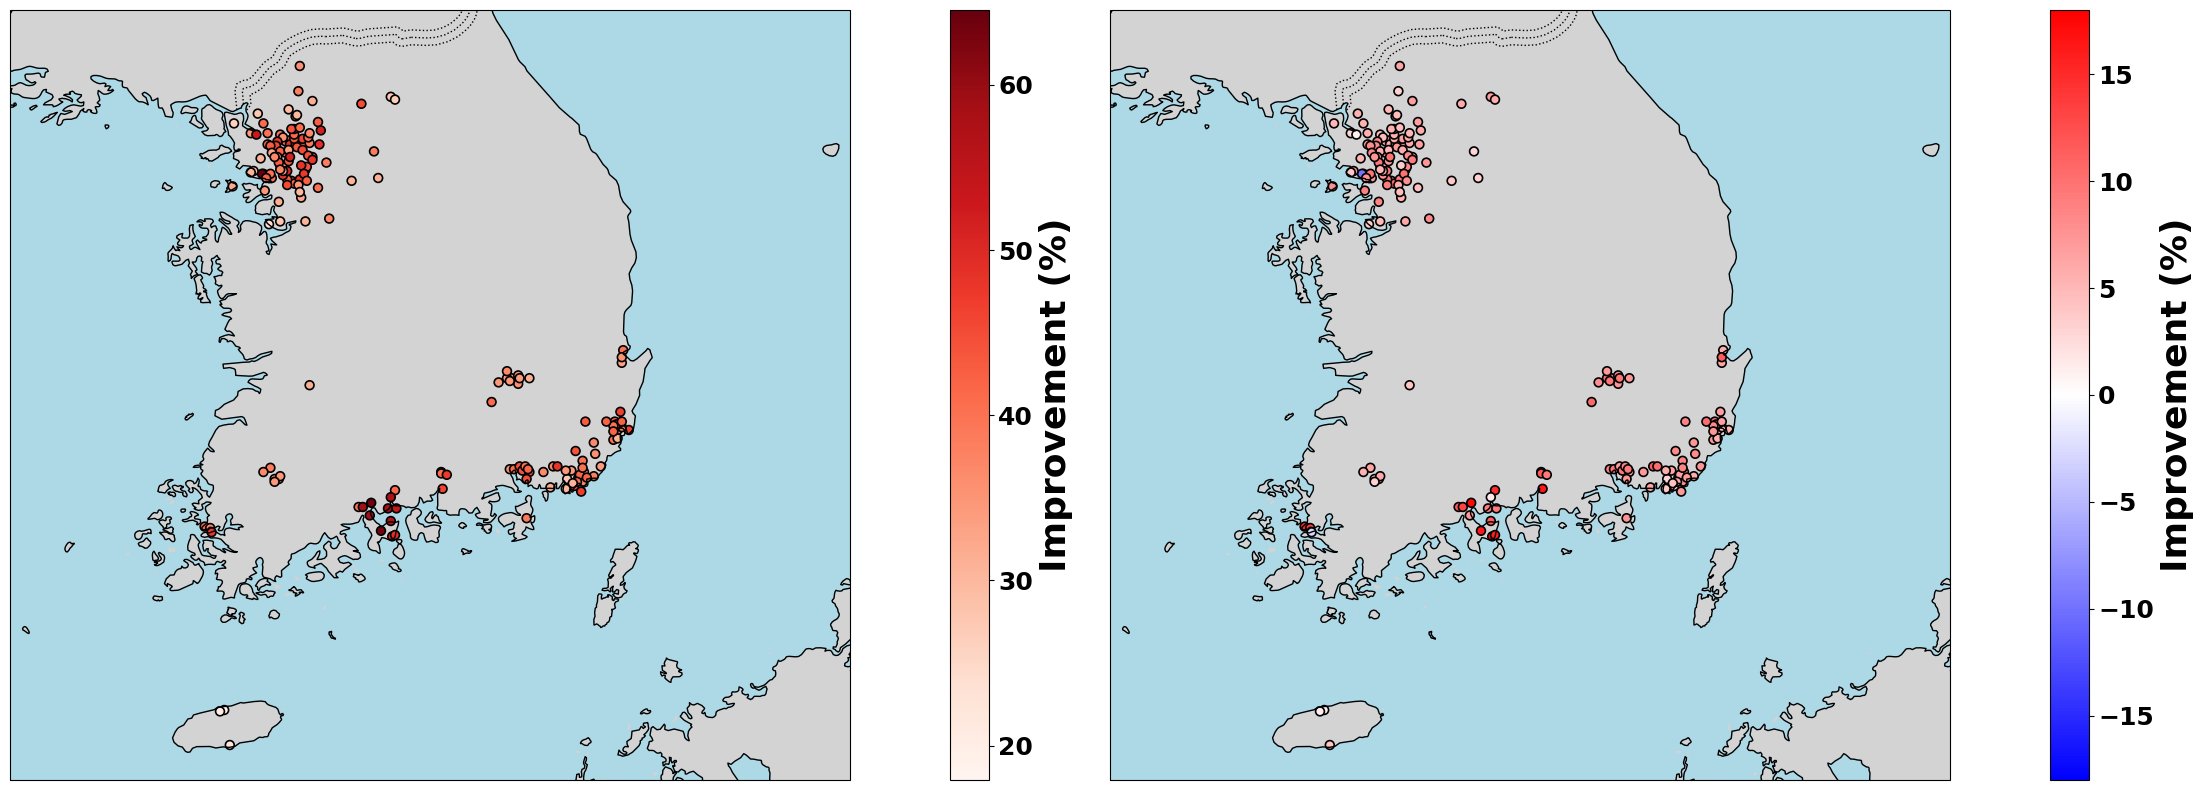

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

nodes = OrderedDict()
folder_path = '/tng4/users/rdimri/korea_srtm/station_wise/'
with open('/tng4/users/rdimri/stations_info_183_lat_lon.csv', 'r') as f:# _201912_distance.csv', 'r') as f:
    for line in f:
        index_long, index_lat, index  = line.rstrip('\n').split(',') #index, longitude, latitude, index_long, index_lat, dist_grid = line.rstrip('\n').split(',')
        index = int(index)
        file_name = 'staion_' + str(index) + '.nc'
        file_path = str(folder_path + file_name)
        assert os.path.isfile(file_path)
        latitude = xr.open_dataset(file_path).lat
        longitude = xr.open_dataset(file_path).lon
        longitude, latitude = float(longitude), float(latitude)
        nodes.update({index: {'lon': longitude, 'lat': latitude}})
        
from scipy.stats import pearsonr
stations = 183
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

def test(pred_baseline, pred_improved, labels):
    rmse_baseline = np.array([pearsonr(labels[:,station,:].flatten(), pred_baseline[:,station,:].flatten())[0]
                       for station in range(stations)])
    rmse_improved = np.array([pearsonr(labels[:,station,:].flatten(), pred_improved[:,station,:].flatten())[0] 
                       for station in range(stations)])
    improvement = 100 * (rmse_improved - rmse_baseline) / rmse_baseline
    return improvement
    # return pearsonr(predictions, targets)[0]#np.sqrt(((predictions - targets) ** 2).mean(axis=0))

def calculate_improvement(pred_baseline, pred_improved, labels):
    rmse_baseline = np.array([calculate_rmse(labels[:,station,:], pred_baseline[:,station,:]) 
                       for station in range(stations)])
    rmse_improved = np.array([calculate_rmse(labels[:,station,:], pred_improved[:,station,:]) 
                       for station in range(stations)])
    improvement = 100 * (rmse_baseline - rmse_improved) / rmse_baseline
    return improvement

def get_station_data(model_improvement):
    nodes_df = pd.DataFrame(nodes)
    nodes_df = nodes_df.transpose()
    lats = np.array(nodes_df.lat)
    lons = np.array(nodes_df.lon)
    improvements = model_improvement 
    return lats, lons, improvements

def plot_improvement(ax, lats, lons, improvements, title):
    ax.set_extent([124, 132, 33, 39], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    
    scatter = ax.scatter(lons, lats, c=improvements, cmap='Reds', 
                         s=30, edgecolor='k', linewidth=1, 
                         transform=ccrs.PlateCarree())
    
    plt.colorbar(scatter, ax=ax, shrink=0.5, label='Improvement (%)')
    ax.set_title(title)

improvement_cmaq = calculate_improvement(pred_cmaq, pred_agat, labe_agat)
improvement_gnn = calculate_improvement(pred_gnn, pred_agat, labe_agat)

lats_cmaq, lons_cmaq, improvements_cmaq = get_station_data(improvement_cmaq)
lats_gnn, lons_gnn, improvements_gnn = get_station_data(improvement_gnn)
# print(lats_cmaq.shape, lons_cmaq.shape, improvements_cmaq.shape)

def plot_improvement(ax, lats, lons, improvements, title, c, colorbar_limit=None, tick_size = 18):
    ax.set_extent([125, 131, 33, 38.5], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    
    cmap = c
    if colorbar_limit:
        vmin, vmax = colorbar_limit
    else:
        vmin, vmax = improvements.min(), improvements.max()
    scatter = ax.scatter(lons, lats, c=improvements, cmap=cmap,
                         s = 40, edgecolor='k', linewidth=1.2,
                         vmin=vmin, vmax=vmax,  # Set the color limits here
                         transform=ccrs.PlateCarree())
    
    cbar = plt.colorbar(scatter, ax=ax, shrink=1.0)#, label='Improvement (%)')
    cbar.set_label('Improvement (%)', fontsize=26, fontweight='bold')
    cbar.ax.tick_params(labelsize = tick_size, labelcolor='black')#labelsize=12, 
    # ax.set_title(title, fontsize = 22, fontweight = 'bold')
    
    for label in cbar.ax.yaxis.get_ticklabels():
        label.set_weight('bold')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 10), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=-0.45)

plot_improvement(ax1, lats_cmaq, lons_cmaq, improvements_cmaq, 'Improvement over CMAQ', 'Reds')#, colorbar_limit=(0, 100))

c = mcolors.LinearSegmentedColormap.from_list('custom_red_blue', ['blue', 'white', 'red'], N=256)
plot_improvement(ax2, lats_gnn, lons_gnn, improvements_gnn,'Improvement over GNN', c, colorbar_limit=(-18, 18))
# plt.savefig('/tng4/users/rdimri/Spatial_improvement_RMSE.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [5]:
import numpy as np
import pandas as pd

def categorize(values, thresholds):
    categories = np.digitize(values, thresholds, right=False) - 1
    categories[categories == -1] = 0
    return categories

def compute_metrics(observed_data, predicted_data, time_points, thresholds):
    metrics = {}
    for t in time_points:
        observed = observed_data[:, :, t:t+24].flatten()
        predicted = predicted_data[:, :, t:t+24].flatten()

        conf_matrix = np.zeros((len(thresholds) - 1, len(thresholds) - 1), dtype=int)
        obs_cat = categorize(observed, thresholds)
        pred_cat = categorize(predicted, thresholds)

        for i in range(len(observed)):
            conf_matrix[obs_cat[i], pred_cat[i]] += 1

        confusion_matrix = np.array(pd.DataFrame(conf_matrix,
                                index=[f'{thresholds[i]}-{thresholds[i+1]-1} µg/m³' for i in range(len(thresholds)-1)],
                                columns=[f'{thresholds[i]}-{thresholds[i+1]-1} µg/m³' for i in range(len(thresholds)-1)]))
        
        a1, b1, c1, d1 = confusion_matrix[0, :]
        a2, b2, c2, d2 = confusion_matrix[1, :]
        a3, b3, c3, d3 = confusion_matrix[2, :]
        a4, b4, c4, d4 = confusion_matrix[3, :]
    
        I = a1+a2+b1+b2
        II = c1+c2+d1+d2
        III = a3+a4+b3+b4
        IV = c3+c4+d3+d4
    
        N = confusion_matrix.sum()
    
        THR = 100*(a1+b2+c3+d4)/N
        HR_high = 100*(c3+d4)/(III+IV)
        FAR = 100*II/(II+IV)
        HR_over = 100*(b1+c1+c2+d1+d2+d3)/N
        HR_under = 100*(a2+a3+a4+b3+b4+c4)/N
        metrics_for_time = {}
        metrics_for_time['THR'] = THR
        metrics_for_time['HR_high'] = HR_high
        metrics_for_time['FAR'] = FAR
        metrics_for_time['HR_over'] = HR_over
        metrics_for_time['HR_under'] = HR_under

        metrics[t] = metrics_for_time

    return metrics, confusion_matrix

time_points = [0, 24, 48]
thresholds = [0, 15, 35, 75, 500]

metrics_agat, _ = compute_metrics(labe_agat, pred_agat, time_points, thresholds)
for t in time_points:
    print(f"Day {t}: {metrics_agat[t]}")
 
print('################################################################')   
metrics_gnn, _ = compute_metrics(labe_gnn, pred_gnn, time_points, thresholds)
for t in time_points:
    print(f"Day {t}: {metrics_gnn[t]}")
    
print('################################################################')
metrics_mlp, _ = compute_metrics(labe_mlp, pred_mlp, time_points, thresholds)
for t in time_points:
    print(f"Day {t}: {metrics_mlp[t]}")

print('################################################################')
metrics_cmaq, d = compute_metrics(labe_agat, pred_cmaq, time_points, thresholds)
for t in time_points:
    print(f"Day {t}: {metrics_cmaq[t]}")
    
print('################################################################')
metrics_lstm, _ = compute_metrics(labe_lstm, pred_lstm, time_points, thresholds)
for t in time_points:
    print(f"Day {t}: {metrics_lstm[t]}")

Day 0: {'THR': 72.94840457425319, 'HR_high': 52.88545610740804, 'FAR': 38.015191829143795, 'HR_over': 13.0636165688644, 'HR_under': 13.987978856882403}
Day 24: {'THR': 69.48172998165052, 'HR_high': 49.489016935430925, 'FAR': 45.252879489767054, 'HR_over': 16.50556991474468, 'HR_under': 14.012700103604809}
Day 48: {'THR': 68.5576173501052, 'HR_high': 51.105947749902484, 'FAR': 47.75791857257691, 'HR_over': 18.07816129216724, 'HR_under': 13.364221357727557}
################################################################
Day 0: {'THR': 70.31818428368881, 'HR_high': 57.699682969074686, 'FAR': 48.73208490394888, 'HR_over': 18.211475220622738, 'HR_under': 11.47034049568846}
Day 24: {'THR': 65.52470116908607, 'HR_high': 56.835884775545814, 'FAR': 56.411888689229684, 'HR_over': 23.179236948905675, 'HR_under': 11.296061882008251}
Day 48: {'THR': 62.727731378465336, 'HR_high': 56.81949020846373, 'FAR': 57.86462364025427, 'HR_over': 26.96855442700318, 'HR_under': 10.303714194531482}
############

/tmp/ipykernel_4005119/3596571202.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
/tmp/ipykernel_4005119/3596571202.py:60: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=0.75)


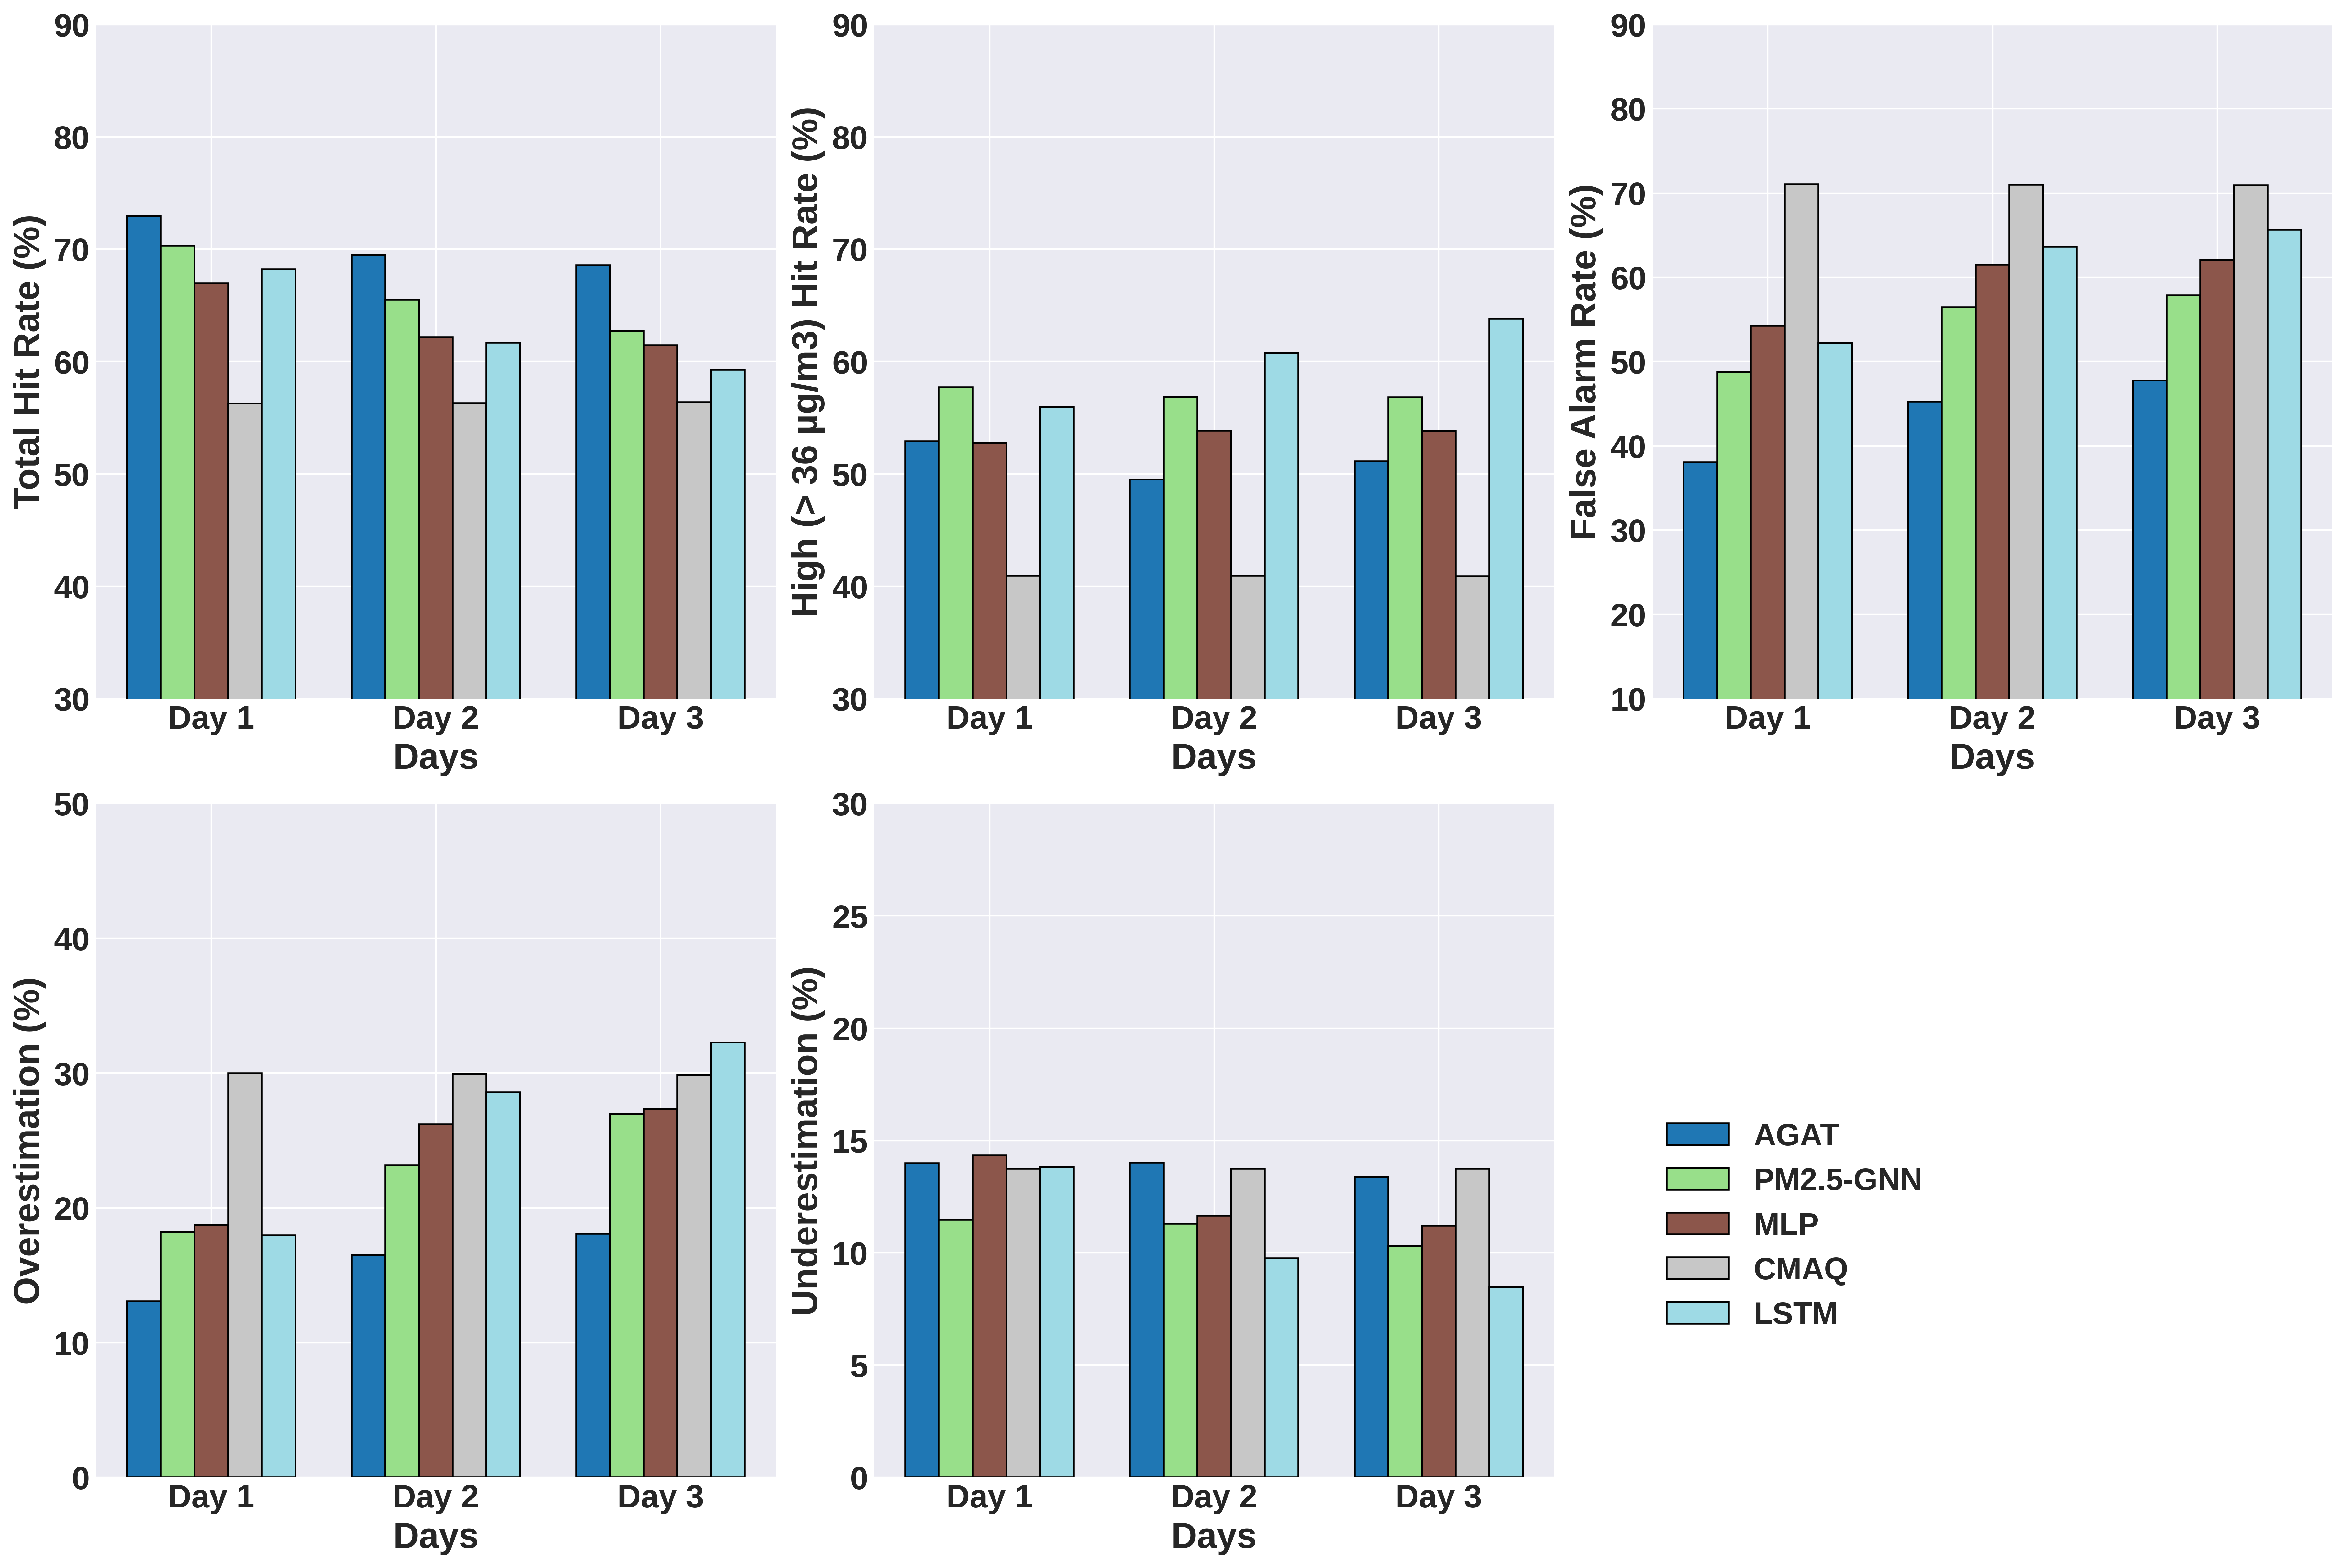

In [6]:
import matplotlib as mpl

# Set default legend size
plt.style.use('seaborn-darkgrid')
def plot_metrics_subplots(metrics_list, model_names, time_points, metrics_names, ylim_dict, full_metric_names):
    n_models = len(metrics_list)
    n_metrics = len(metrics_names)
    bar_width = 0.15  # Adjust bar width to fit all models if necessary

    # Determine the layout of the subplots
    nrows = int(np.sqrt(n_metrics))
    ncols = int(np.ceil(n_metrics / nrows))
    
    # Increase figsize and specify DPI for high-resolution figures
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 6), dpi=400, constrained_layout=True)
    mpl.rcParams['legend.fontsize'] = 'xx-large'
    
    
    # Flatten the axes array for easy indexing
    if nrows * ncols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Use a visually appealing and distinguishable color palette
    color_cycle = plt.cm.tab20(np.linspace(0, 1, n_models))
    
    for idx, (metric_name, full_name) in enumerate(zip(metrics_names, full_metric_names)):
        ax = axes[idx]
        index = np.arange(len(time_points))
        
        for i, (metrics, name) in enumerate(zip(metrics_list, model_names)):
            values = [metrics[time][metric_name] for time in time_points]
            ax.bar(index + i * bar_width, values, bar_width, label=name if idx == 0 else "",
                   color=color_cycle[i], edgecolor = 'black', linewidth = 1)
            
        
        # Increase font sizes for better visibility
        ax.set_xlabel('Days', fontsize=20, fontweight='bold')
        ax.set_ylabel(full_name, fontsize=20, fontweight='bold')
        # ax.set_title(full_name, fontsize=18, fontweight='bold')
        ax.set_xticks(index + bar_width * (n_models - 1) / 2)
        ax.set_xticklabels(['Day 1', 'Day 2', 'Day 3'], fontsize=14)
        
        # Set custom y-axis limits based on the metric
        if metric_name in ylim_dict:
            ax.set_ylim(ylim_dict[metric_name])
        
        # Make y-ticks more visible
        for label in ax.get_yticklabels():
            label.set_fontsize(18)
            label.set_fontweight('bold')
        
        for label in ax.get_xticklabels():
            label.set_fontsize(18)
            label.set_fontweight('bold')
    # Place the legend outside the last subplot
    if n_metrics > 0:
        # Adjust the subplot to make space for the legend
        plt.subplots_adjust(right=0.75)
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.7, 0.3), fontsize=60, prop={'weight':'bold'})
    
    # Hide any unused subplots
    for idx in range(n_metrics, nrows * ncols):
        if idx < len(axes):  # Check to avoid index out of range error
            fig.delaxes(axes[idx])
    
    plt.savefig('/tng4/users/rdimri/PM2.5-Graphs/cat.jpg', dpi = 400, bbox_inches = 'tight')
    plt.show()

model_names = ['AGAT', 'PM2.5-GNN', 'MLP', 'CMAQ', 'LSTM']
metrics_list = [metrics_agat, metrics_gnn, metrics_mlp, metrics_cmaq, metrics_lstm]
metrics_names = ['THR', 'HR_high', 'FAR', 'HR_over', 'HR_under']
ylim_dict = {
    'THR': (30, 90),
    'HR_high': (30, 90),
    'FAR': (10, 90),
    'HR_over': (0, 50),
    'HR_under': (0, 30)
}
full_metric_names = [
    'Total Hit Rate (%)', 
    'High (> 36 µg/m3) Hit Rate (%)', 
    'False Alarm Rate (%)', 
    'Overestimation (%)', 
    'Underestimation (%)'
]

plot_metrics_subplots(metrics_list, model_names, time_points, metrics_names, ylim_dict, full_metric_names)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

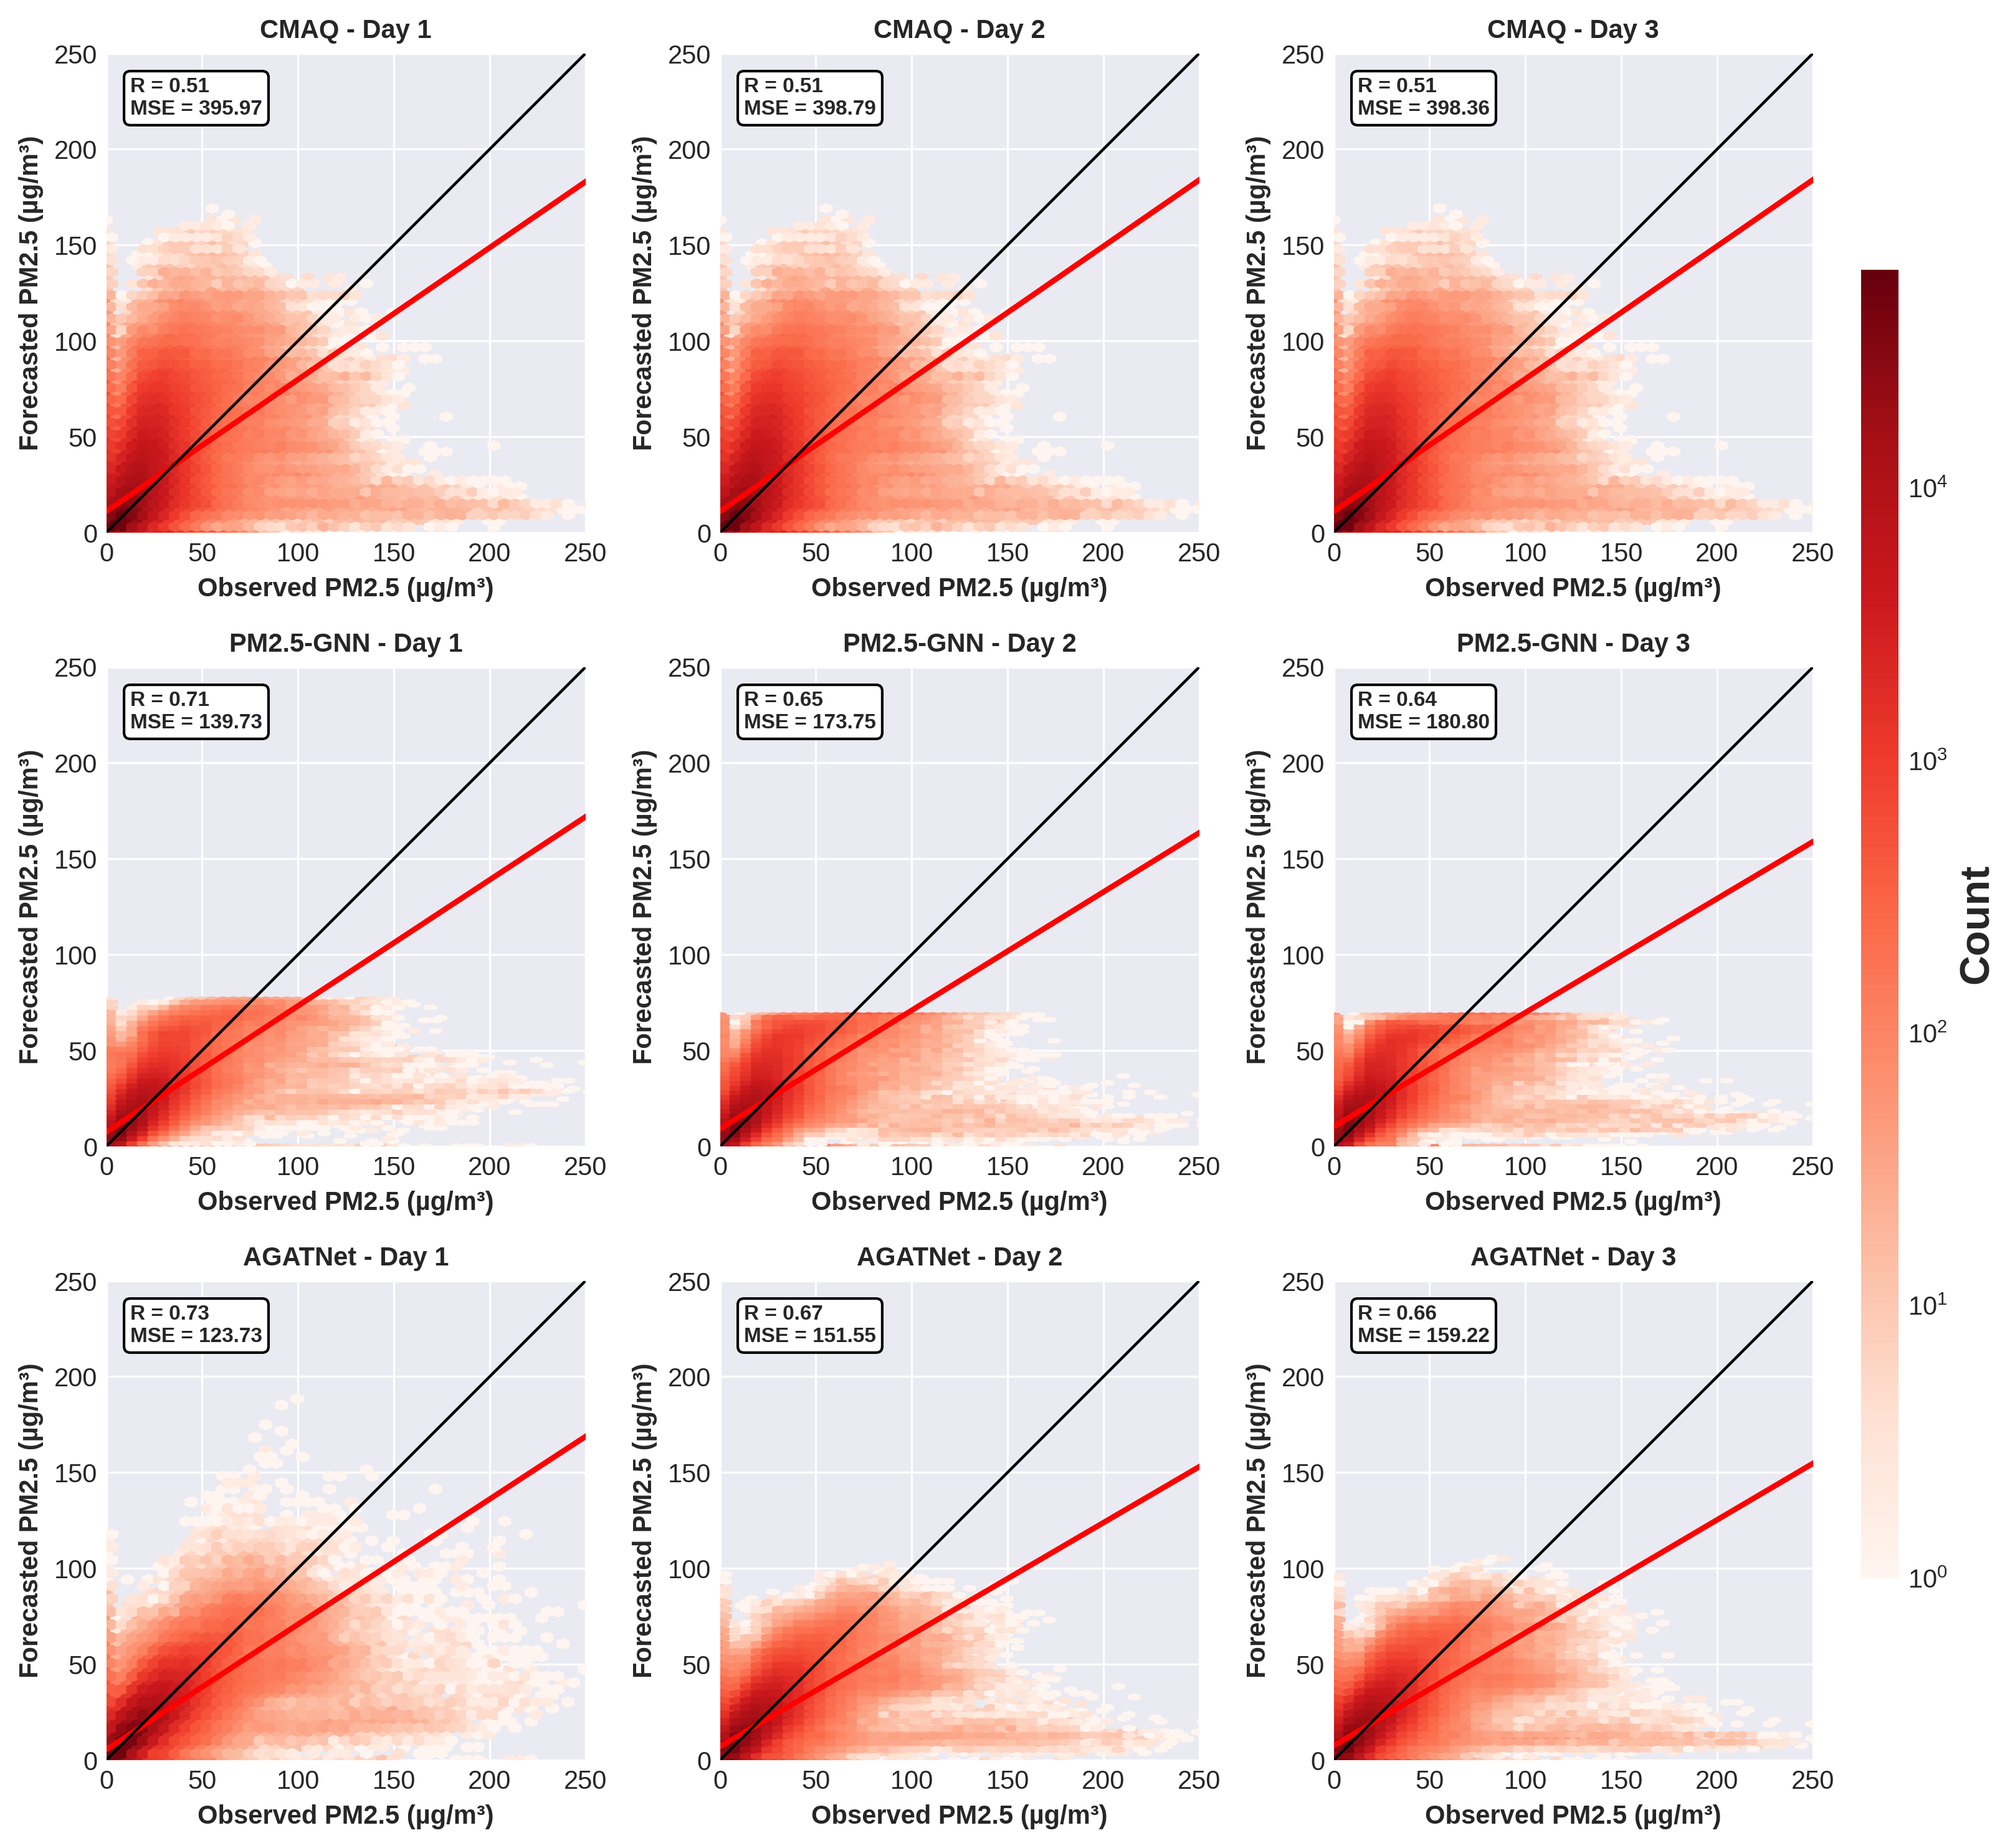

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import linregress


data_structure = {
    'CMAQ': {
        'Day 1': (labe_agat[::24, :, 0:24], pred_cmaq[::24, :, 0:24]),
        'Day 2': (labe_agat[::24, :, 24:48], pred_cmaq[::24, :, 24:48]),
        'Day 3': (labe_agat[::24, :, 48:], pred_cmaq[::24, :, 48:])
    },
    'PM2.5-GNN': {
        'Day 1': (labe_gnn[::24, :, 0:24], pred_gnn[::24, :, 0:24]),
        'Day 2': (labe_gnn[::24, :, 24:48], pred_gnn[::24, :, 24:48]),
        'Day 3': (labe_gnn[::24, :, 48:], pred_gnn[::24, :, 48:])
    },
    'AGATNet': {
        'Day 1': (labe_agat[::24, :, 0:24], pred_agat[::24, :, 0:24]),
        'Day 2': (labe_agat[::24, :, 24:48], pred_agat[::24, :, 24:48]),
        'Day 3': (labe_agat[::24, :, 48:], pred_agat[::24, :, 48:])
    }
}

axis_limits = (0, 250)
fig, axes = plt.subplots(3, 3, figsize=(10, 10), dpi=300)
for i, (model, days_data) in enumerate(data_structure.items()):
    for j, (day, (labels, preds)) in enumerate(days_data.items()):
        ax = axes[i, j]
        ax.set_xlim(axis_limits)
        ax.set_ylim(axis_limits)
        
        # Set equal aspect ratio
        ax.set_aspect('equal', 'box')
        
        # Set tick spacing to 50 units
        ax.xaxis.set_ticks(np.arange(axis_limits[0], axis_limits[1] + 1, 50))
        ax.yaxis.set_ticks(np.arange(axis_limits[0], axis_limits[1] + 1, 50))
        
        # r2 = pearsonr(labels.flatten(), preds.flatten())[0] #r2_score(labels.flatten(), preds.flatten())
        mse = mean_squared_error(labels.flatten(), preds.flatten())


        slope, intercept, r_value, _, _ = linregress(labels.flatten(), preds.flatten())
        line = slope * labels.flatten() + intercept


        hb = ax.hexbin(labels.flatten(), preds.flatten(), gridsize=50, cmap='Reds', bins='log', mincnt=1)#Blues
        ax.plot(labels.flatten(), line, color='red', lw=2)
        ax.plot(labels.flatten(), labels.flatten(), color='black', lw=1)

        stats_text = f'R = {r_value:.2f}\nMSE = {mse:.2f}'
        bbox_props = dict(boxstyle='round,pad=0.3', ec='black', lw=1, fc='white')
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize = 8, verticalalignment='top', bbox=bbox_props, fontweight = 'bold')

        ax.set_title(f'{model} - {day}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Observed PM2.5 (µg/m³)', fontsize=10, fontweight='bold')
        ax.set_ylabel('Forecasted PM2.5 (µg/m³)', fontsize=10, fontweight='bold')


        legend = ax.legend()
        legend.get_frame().set_linewidth(1.5)

cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7]) # Adjust the location accordingly
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.set_label('Count', fontsize=16, fontweight='bold')  # Set fontsize and weight here

plt.tight_layout()
# plt.savefig('/tng4/users/rdimri/multi_model_hexbin_plots_with_stats.jpg', format='jpg', dpi=400, bbox_inches='tight')
plt.show()

In [38]:
import pandas as pd

aqs_site_info_df = pd.read_csv('/tng4/users/rdimri/Korea_AQS_site_info_Oct_2021_updated.csv')
stations_info_df = pd.read_csv('/tng4/users/rdimri/stations_info_183_lat_lon.csv', header = None)

stations_info_df.columns = ['Lat', 'Lon', 'Station_ID']
merged_df = pd.merge(stations_info_df, aqs_site_info_df[['Station_ID', 'Province']], on='Station_ID', how='left')
merged_df.to_csv('/tng4/users/rdimri/merged_stations_info.csv')
province_indices = merged_df.groupby('Province').apply(lambda x: x.index.tolist()).to_dict()

province_indices_length = {province: len(indices) for province, indices in province_indices.items()}


for province, length in province_indices_length.items():
    print(f"Province: {province}, Number of Stations: {length}")

Province: Busan, Number of Stations: 19
Province: Chonbuk, Number of Stations: 1
Province: Chonnam, Number of Stations: 14
Province: Daegu, Number of Stations: 10
Province: Gangwon_West, Number of Stations: 2
Province: Gwangju, Number of Stations: 6
Province: Gyeongbuk, Number of Stations: 3
Province: Gyeonggi_North, Number of Stations: 17
Province: Gyeonggi_South, Number of Stations: 50
Province: Gyeongnam, Number of Stations: 19
Province: Jeju, Number of Stations: 3
Province: Seoul, Number of Stations: 25
Province: Ulsan, Number of Stations: 14


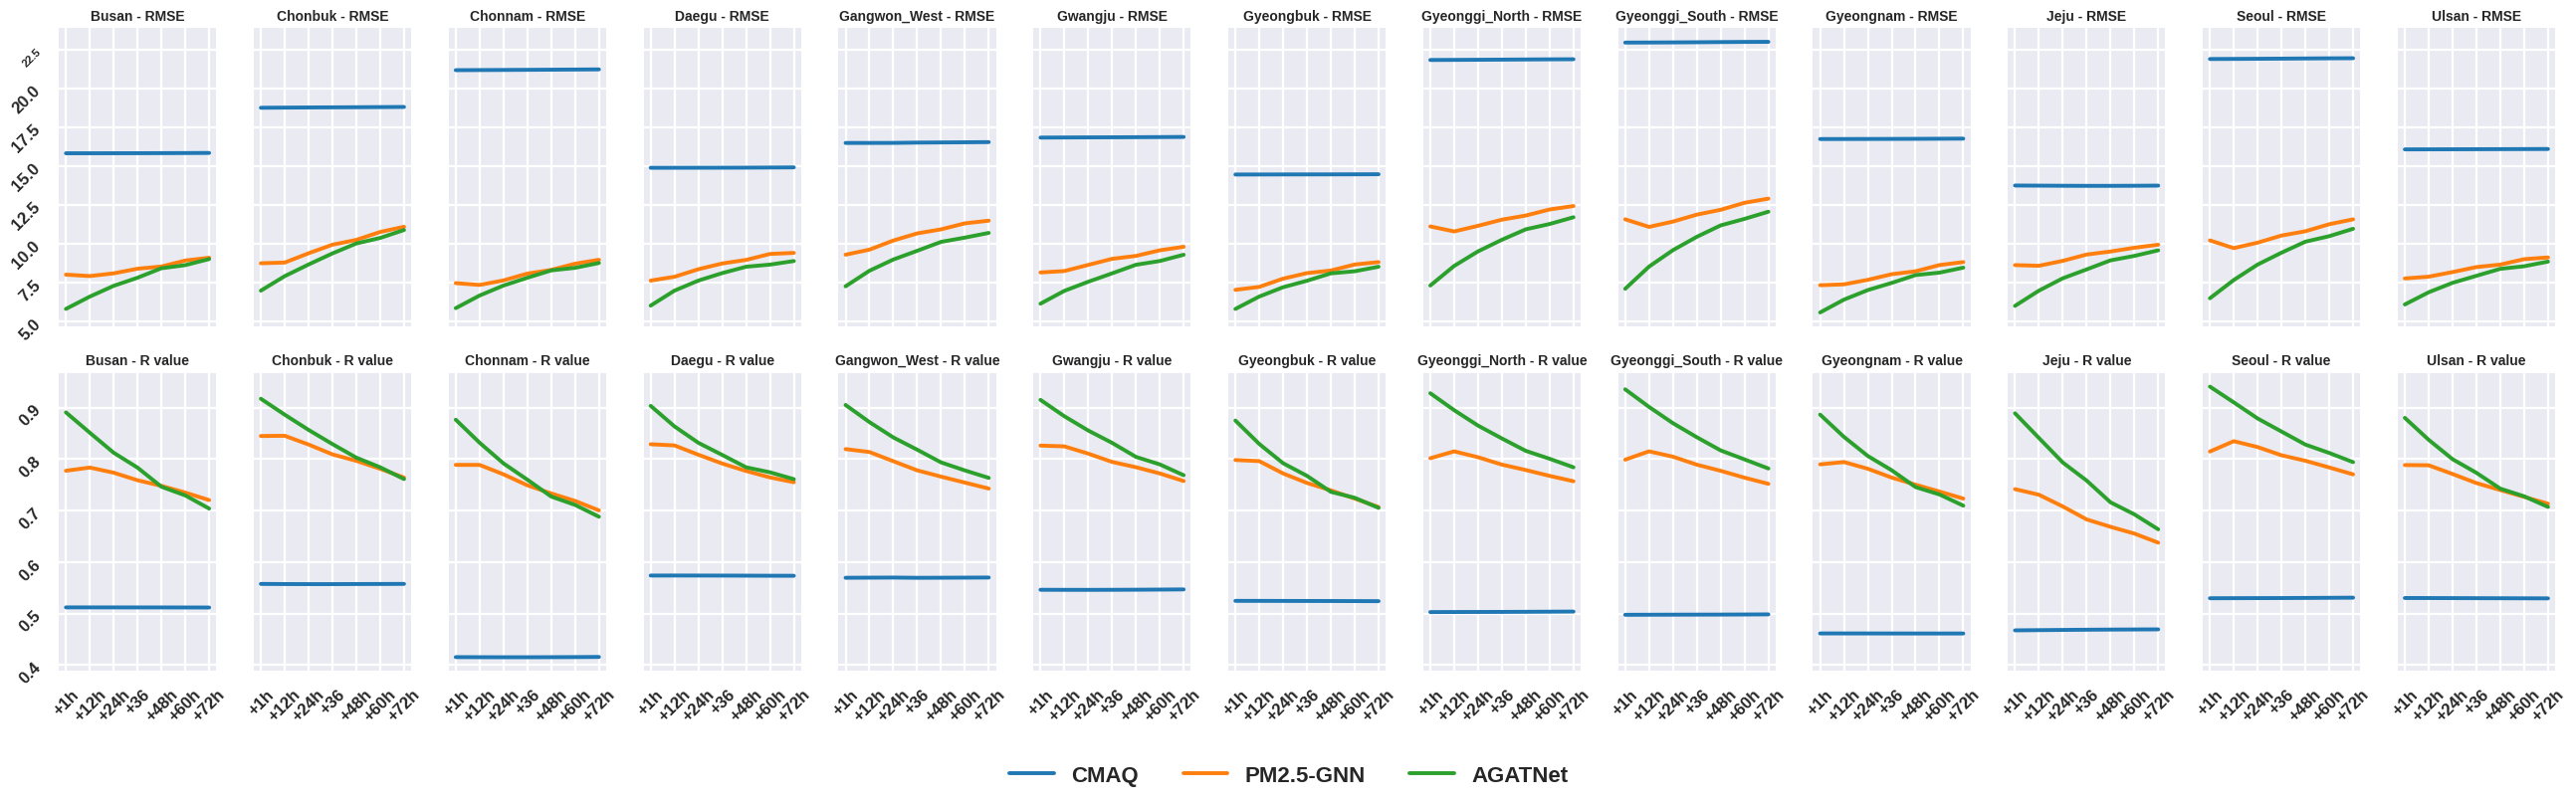

In [39]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from matplotlib.font_manager import FontProperties

# province_names = list(province_indices.keys())
province_names = [
    "Busan", "Chonbuk", "Chonnam", "Daegu", "Gangwon W", "Gwangju",
    "Gyeongbuk", "Gyeonggi N", "Gyeonggi S", "Gyeongnam",
    "Jeju", "Seoul", "Ulsan"
]
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def calculate_pearson(actual, predicted):
    return pearsonr(actual.flatten(), predicted.flatten())[0]

metrics = {model: {'RMSE': [], 'Pearson': []} for model in ['CMAQ', 'PM2.5-GNN', 'AGATNet']}

time_indices = [0, 11, 23, 35, 47, 59, 71]

for model, (labe, pred) in [('CMAQ', (labe_agat, pred_cmaq)),
                            ('PM2.5-GNN', (labe_gnn, pred_gnn)),
                            ('AGATNet', (labe_agat, pred_agat))
                            ]:
    for province_name in province_indices:
        actual = labe if province_name == 'Entire region' else labe[:, province_indices[province_name], :]
        predicted = pred if province_name == 'Entire region' else pred[:, province_indices[province_name], :]#[:, province_index, time_indices]
        
        # Calculate RMSE and Pearson for each time point
        rmse_time = [calculate_rmse(actual[:, :,t], predicted[:, :, t]) for t in range(len(time_indices))]
        pearson_time = [calculate_pearson(actual[:, :, t], predicted[:, :, t]) for t in range(len(time_indices))]
        # print(province_name, pearson_time)
        
        metrics[model]['RMSE'].append(rmse_time)
        metrics[model]['Pearson'].append(pearson_time)

time_labels = ['+1h', '+12h', '+24h', '+36', '+48h', '+60h', '+72h']

fig, axs = plt.subplots(2, len(province_names), figsize=(len(province_names) * 2, 8), sharex='col', sharey='row')

for i, province_name in enumerate(province_indices):
    axs[0, i].set_title(f'{province_name} - RMSE', fontsize=10, fontweight='bold')
    axs[1, i].set_title(f'{province_name} - R value', fontsize=10, fontweight='bold')
    
    for model in metrics:
        rmse_values = metrics[model]['RMSE'][i]
        pearson_values = metrics[model]['Pearson'][i]
        # print(f'{province_name}', rmse_values, pearson_values)
        
        axs[0, i].plot(time_labels, rmse_values, label=model)
        axs[1, i].plot(time_labels, pearson_values, label=model)
        
        axs[0, i].tick_params(axis='x', labelsize=8, labelrotation = 45)
        axs[0, i].tick_params(axis='y', labelsize=8, labelrotation = 45)
        axs[1, i].tick_params(axis='x', labelsize=8, labelrotation = 45)
        axs[1, i].tick_params(axis='y', labelsize=8, labelrotation = 45)
        for ax in [axs[0, i], axs[1, i]]:
            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontsize(12)
                label.set_fontweight('bold')
                label.rotation = 90

# Adjusting legend position
font_prop = FontProperties(weight='bold', size=16)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=len(metrics), prop=font_prop)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
# plt.savefig('/tng4/users/rdimri/time_series_all.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()

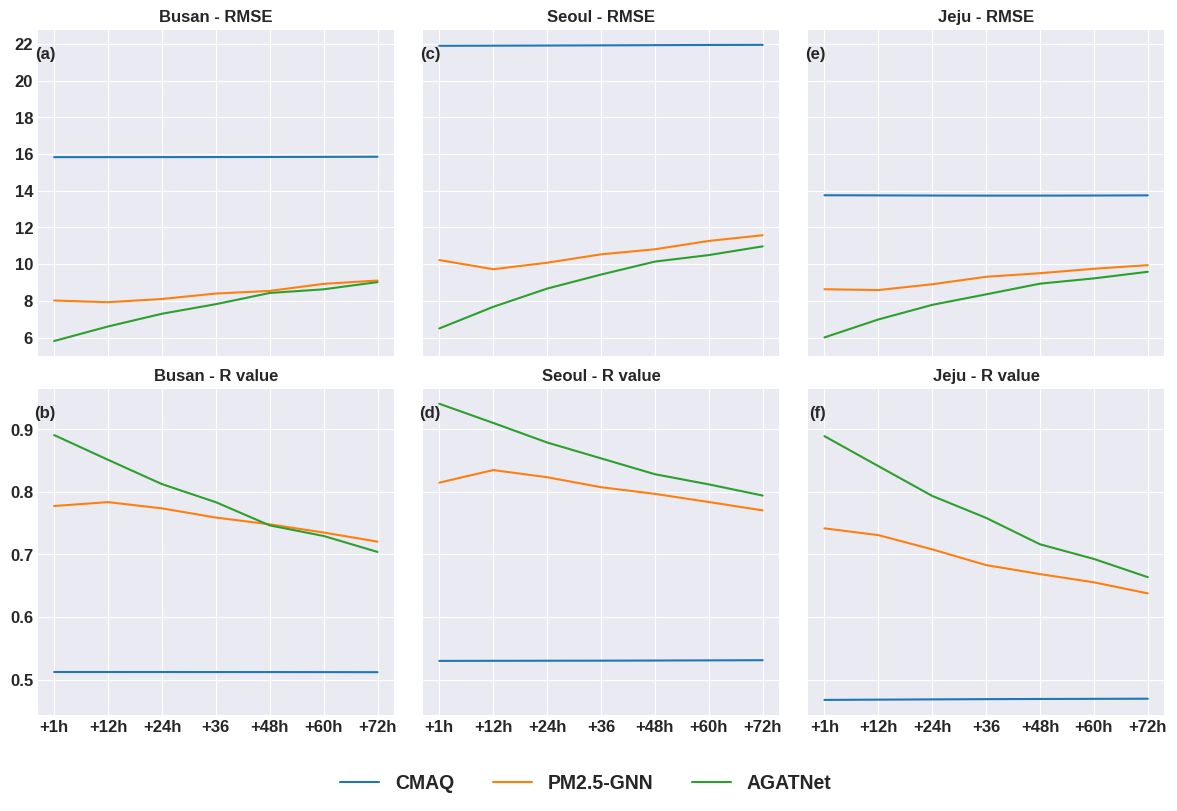

In [17]:
from matplotlib.font_manager import FontProperties
selected_provinces = ['Busan', 'Seoul', 'Jeju']
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Adjust the size of the subplots to fit the selected provinces
fig, axs = plt.subplots(2, len(selected_provinces), figsize=(len(selected_provinces) * 4, 8), sharex='col', sharey='row')

for i, province_name in enumerate(province_names):
    if province_name not in selected_provinces:
        continue  # Skip provinces that are not selected

    # Find the index of the current province in the selected provinces list
    selected_index = selected_provinces.index(province_name)

    axs[0, selected_index].set_title(f'{province_name} - RMSE', fontsize=12, fontweight='bold')
    axs[1, selected_index].set_title(f'{province_name} - R value', fontsize=12, fontweight='bold')
    
    for model in metrics:
        rmse_values = metrics[model]['RMSE'][i]
        pearson_values = metrics[model]['Pearson'][i]
        
        axs[0, selected_index].plot(time_labels, rmse_values, label=model)
        axs[1, selected_index].plot(time_labels, pearson_values, label=model)
        
        # Make x-ticks and y-ticks bigger and bold
        axs[0, selected_index].tick_params(axis='x', labelsize=12)#, labelweight='bold')
        axs[0, selected_index].tick_params(axis='y', labelsize=12)#, labelweight='bold')
        axs[1, selected_index].tick_params(axis='x', labelsize=12)#, labelweight='bold')
        axs[1, selected_index].tick_params(axis='y', labelsize=12)#, labelweight='bold')
        for ax in [axs[0, selected_index], axs[1, selected_index]]:
            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontsize(12)
                label.set_fontweight('bold')

    # Add subplot labels on the top right corner of each subplot
    axs[0, selected_index].text(0.05, 0.95, subplot_labels[2 * selected_index], transform=axs[0, selected_index].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', fontweight='bold')
    axs[1, selected_index].text(0.05, 0.95, subplot_labels[2 * selected_index + 1], transform=axs[1, selected_index].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', fontweight='bold')

font_prop = FontProperties(weight='bold', size=14)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=len(metrics), prop=font_prop)
# fig.legend(fontsize=24, prop={'weight':'bold'})

plt.tight_layout()
plt.subplots_adjust(bottom=0.10)  # Adjust bottom to make space for the legend
# plt.savefig('/tng4/users/rdimri/time_series_busan_seoul_jeju.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()

In [19]:
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def calculate_pearson(actual, predicted):
    return pearsonr(actual.flatten(), predicted.flatten())[0]

metrics = {model: {'RMSE': [], 'Pearson': [], 'MSE': []} for model in ['CMAQ', 'PM2.5GNN-GRU', 'AGATNet', 'MLP', 'LSTM']}

time_indices = [23, 47, 71]

province_names = [
    "Busan", "Chonbuk", "Chonnam", "Daegu", "Gangwon_West", "Gwangju",
    "Gyeongbuk", "Gyeonggi N", "Gyeonggi S", "Gyeongnam",
    "Jeju", "Seoul", "Ulsan"
]

for model, (labe, pred) in [('CMAQ', (labe_agat, pred_cmaq)),
                            ('PM2.5GNN-GRU', (labe_gnn, pred_gnn)),
                            ('AGATNet', (labe_agat, pred_agat)),
                            ('MLP', (labe_mlp, pred_mlp)),
                            ('LSTM', (labe_lstm, pred_lstm)),
                            ]:
    for province_name in province_indices:
        actual = labe if province_name == 'Entire region' else labe[:, province_indices[province_name], :]
        predicted = pred if province_name == 'Entire region' else pred[:, province_indices[province_name], :]#[:, province_index, time_indices]
        
        # print(province_name)
        rmse_time = [calculate_rmse(actual[:, :, t].flatten(), predicted[:, :, t].flatten()) for t in time_indices]
        pearson_time = [calculate_pearson(actual[:, :, t].flatten(), predicted[:, :, t].flatten()) for t in time_indices]
        mse_time = [mean_squared_error(actual[:, :,t].flatten(), predicted[:, :, t].flatten()) for t in time_indices]
        
        metrics[model]['RMSE'].append(rmse_time)
        metrics[model]['Pearson'].append(pearson_time)
        metrics[model]['MSE'].append(mse_time)

num_provinces = 13  
angles = np.linspace(0, 2 * np.pi, num_provinces, endpoint=False).tolist()
angles += angles[:1]

mse_data = {
    'CMAQ': np.array(metrics['CMAQ']['MSE']),
    'PM2.5GNN-GRU': np.array(metrics['PM2.5GNN-GRU']['MSE']),
    'AGATNet': np.array(metrics['AGATNet']['MSE']),
    'MLP': np.array(metrics['MLP']['MSE']),
    'LSTM': np.array(metrics['LSTM']['MSE'])
}
# average_rmse = np.mean([model_rmse for model_rmse in rmse_data.values()], axis=0)

# Calculate skill scores for each model, province, and forecasting hour
skill_scores = {model: 1 - (model_mse / mse_data['CMAQ'])
                for model, model_mse in mse_data.items() if model != 'CMAQ'}

forecasting_hours = ['+24', '+48', '+72']
forecasting_indices = time_indices = [23, 47, 71]#[0, 23, 47, 71]

/tmp/ipykernel_4005119/3169382369.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


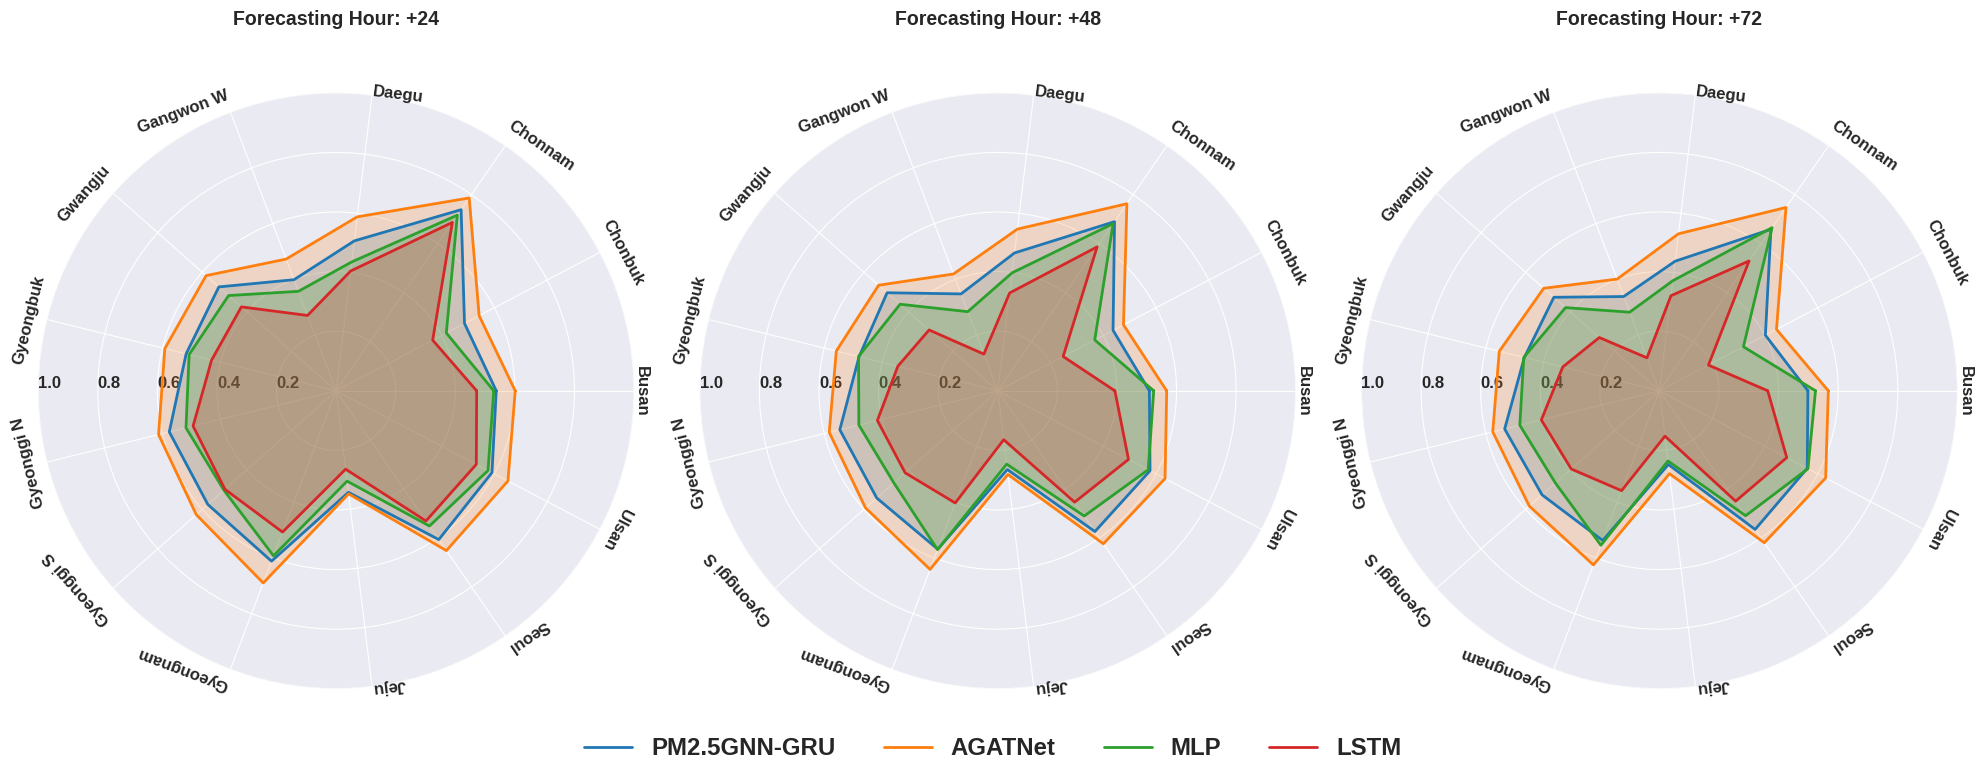

In [20]:
from matplotlib.font_manager import FontProperties
plt.style.use('seaborn-darkgrid')
province_names = [
    "Busan", "Chonbuk", "Chonnam", "Daegu", "Gangwon W", "Gwangju",
    "Gyeongbuk", "Gyeonggi N", "Gyeonggi S", "Gyeongnam",
    "Jeju", "Seoul", "Ulsan"
]
fig, axs = plt.subplots(1, 3, figsize=(20, 10), subplot_kw=dict(polar=True))
r_axis_min = 0  # Minimum r-axis value
r_axis_max = 1.0
r_ticks = [0.2, 0.4, 0.6, 0.8, 1.0]
for idx, ax in enumerate(axs):
    ax.set_ylim(r_axis_min, r_axis_max)
    for model, values in skill_scores.items():
        values_with_closure = np.append(values[:, idx], values[0, idx])  
        ax.plot(angles, values_with_closure, label=model, linewidth = 2)
        ax.fill(angles, values_with_closure, alpha=0.20)
    
    ax.set_yticks(r_ticks)
    ax.set_yticklabels([str(rt) for rt in r_ticks], fontsize=12, fontweight='bold')
    ax.set_rlabel_position(180)
    ax.set_xticks(angles[:-1])
    for i, label in enumerate(province_names):
        if angles[i] >= np.pi/2 and angles[i] <= 3*np.pi/2:
            alignment = "right"
        else:
            alignment = "left"
        ax.text(angles[i], ax.get_rmax() + 0.00, label, size='large', horizontalalignment=alignment, verticalalignment='center', rotation=angles[i]*180/np.pi - 90, fontweight = 'bold')

    ax.set_xticklabels([])
    # ax.set_xticklabels(province_names)
    ax.set_title(f"Forecasting Hour: {forecasting_hours[idx]}", fontsize = 14, fontweight = 'bold', y = 1.1)

lines, labels = axs[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.20), ncol=len(skill_scores), prop = FontProperties(weight='bold', size = 'xx-large'))
# plt.tight_layout()
fig.tight_layout(rect=[0, 0.1, 1, 0.95])
# plt.savefig('/tng4/users/rdimri/skill_score_radar.jpg', format = 'jpg', dpi = 400, bbox_inches = 'tight')
plt.show()

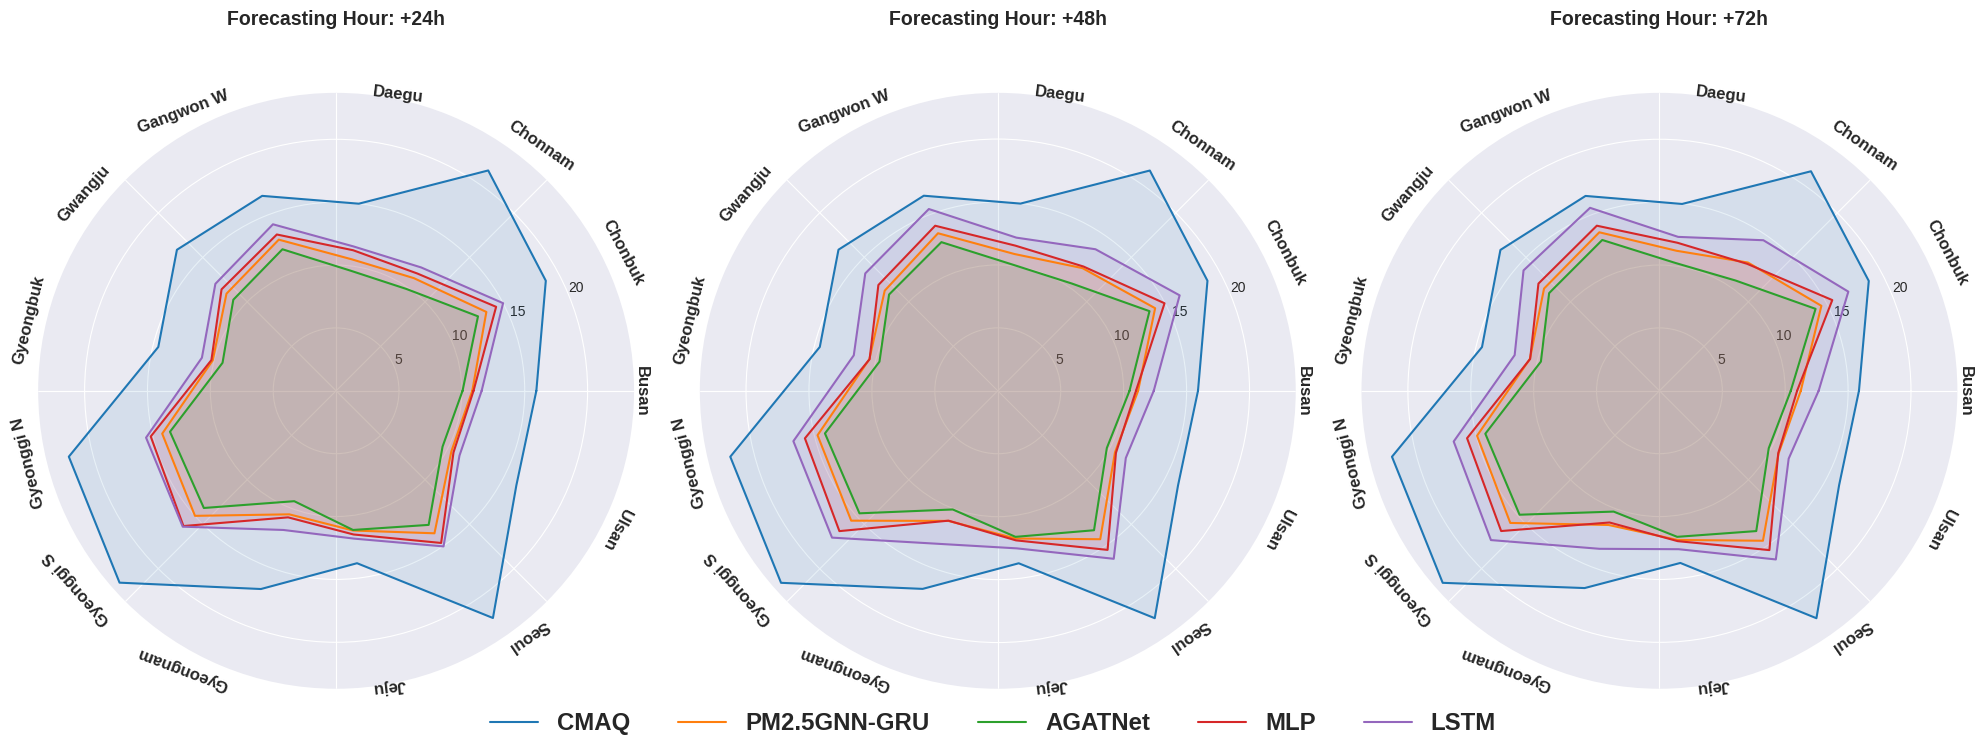

In [21]:
num_provinces = 13  
angles = np.linspace(0, 2 * np.pi, num_provinces, endpoint=False).tolist()
angles += angles[:1]

pearson_dummy_data = {
    'CMAQ': np.array(metrics['CMAQ']['RMSE']),
    'PM2.5GNN-GRU': np.array(metrics['PM2.5GNN-GRU']['RMSE']),
    'AGATNet': np.array(metrics['AGATNet']['RMSE']),
    'MLP': np.array(metrics['MLP']['RMSE']),
    'LSTM': np.array(metrics['LSTM']['RMSE'])
}

forecasting_hours = ['+24h', '+48h', '+72h']
forecasting_indices = [23, 47, 71]

fig, axs = plt.subplots(1, 3, figsize=(20, 10), subplot_kw=dict(polar=True))

for idx, ax in enumerate(axs):
    for model, values in pearson_dummy_data.items():
        values_with_closure = np.append(values[:, idx], values[0, idx])  # Complete the radar chart loop
        ax.plot(angles, values_with_closure, label=model)
        ax.fill(angles, values_with_closure, alpha=0.1)
    
    for i, label in enumerate(province_names):
        if angles[i] >= np.pi/2 and angles[i] <= 3*np.pi/2:
            alignment = "right"
        else:
            alignment = "left"
        ax.text(angles[i], ax.get_rmax() + 0.00, label, size='large', horizontalalignment=alignment, verticalalignment='center', rotation=angles[i]*180/np.pi - 90, fontweight = 'bold')

    ax.set_xticklabels([])
    # ax.set_xticklabels(province_names)
    ax.set_title(f"Forecasting Hour: {forecasting_hours[idx]}", fontsize = 14, fontweight = 'bold', y = 1.1)
    # ax.set_xticks(angles[:-1])
    # ax.set_xticklabels(province_names)

    # ax.set_title(f"Forecasting Hour: {forecasting_hours[idx]}", fontsize = 14, fontweight = 'bold')
# lines, labels = axs[0].get_legend_handles_labels()
# fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.20), ncol=len(skill_scores), prop = FontProperties(weight='bold', size = 'xx-large'))
lines, labels = axs[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.20), ncol=len(pearson_dummy_data), prop = FontProperties(weight='bold', size = 'xx-large'))

plt.tight_layout()
# plt.savefig('/tng4/users/rdimri/RMSE_radar.jpg', format = 'jpg', dpi = 400, bbox_inches = 'tight')
plt.show()

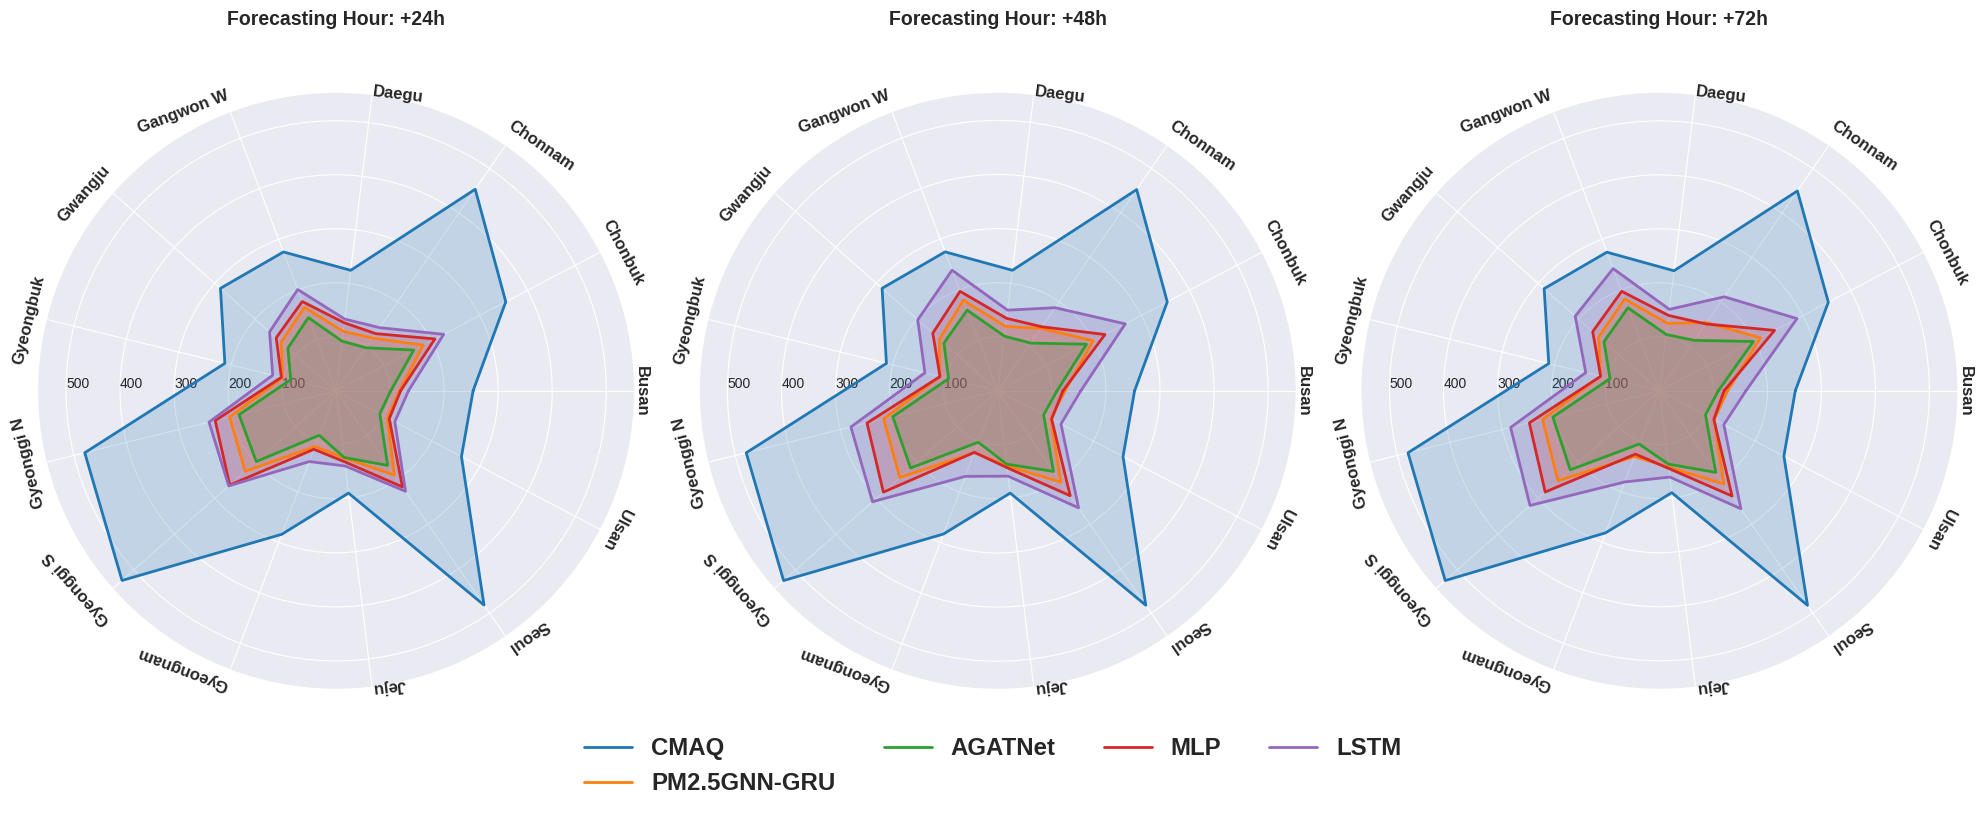

In [22]:
num_provinces = 13  
angles = np.linspace(0, 2 * np.pi, num_provinces, endpoint=False).tolist()
angles += angles[:1]

pearson_dummy_data = {
    'CMAQ': np.array(metrics['CMAQ']['MSE']),
    'PM2.5GNN-GRU': np.array(metrics['PM2.5GNN-GRU']['MSE']),
    'AGATNet': np.array(metrics['AGATNet']['MSE']),
    'MLP': np.array(metrics['MLP']['MSE']),
    'LSTM': np.array(metrics['LSTM']['MSE'])
}

forecasting_hours = ['+24h', '+48h', '+72h']
forecasting_indices = [23, 47, 71]

fig, axs = plt.subplots(1, 3, figsize=(20, 10), subplot_kw=dict(polar=True))

# Customize the radar charts for publication quality visuals
for idx, ax in enumerate(axs):
    # Loop through the models and plot their skill scores
    for model, scores in pearson_dummy_data.items():
        values_with_closure = np.append(scores[:, idx], scores[0, idx])  
        ax.plot(angles, values_with_closure, label=model, linewidth = 2)
        ax.fill(angles, values_with_closure, alpha=0.20)
    
    # ax.set_yticks(r_ticks)
    # ax.set_yticklabels([str(rt) for rt in r_ticks], fontsize=10, fontweight='bold')
    ax.set_rlabel_position(180)
    ax.set_xticks(angles[:-1])
    for i, label in enumerate(province_names):
        if angles[i] >= np.pi/2 and angles[i] <= 3*np.pi/2:
            alignment = "right"
        else:
            alignment = "left"
        ax.text(angles[i], ax.get_rmax() + 0.00, label, size='large', horizontalalignment=alignment, verticalalignment='center', rotation=angles[i]*180/np.pi - 90, fontweight = 'bold')

    ax.set_xticklabels([])
    # ax.set_xticklabels(province_names)
    ax.set_title(f"Forecasting Hour: {forecasting_hours[idx]}", fontsize = 14, fontweight = 'bold', y = 1.1)

lines, labels = axs[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.20), ncol=len(skill_scores), prop = FontProperties(weight='bold', size = 'xx-large'))
# plt.tight_layout()
fig.tight_layout(rect=[0, 0.1, 1, 0.95])
# plt.savefig('/tng4/users/rdimri/MSE_radar.jpg', format = 'jpg', dpi = 400, bbox_inches = 'tight')
plt.show()
# plt.savefig

/tmp/ipykernel_4005119/164597834.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster') # This will make the figures larger and fonts more visible


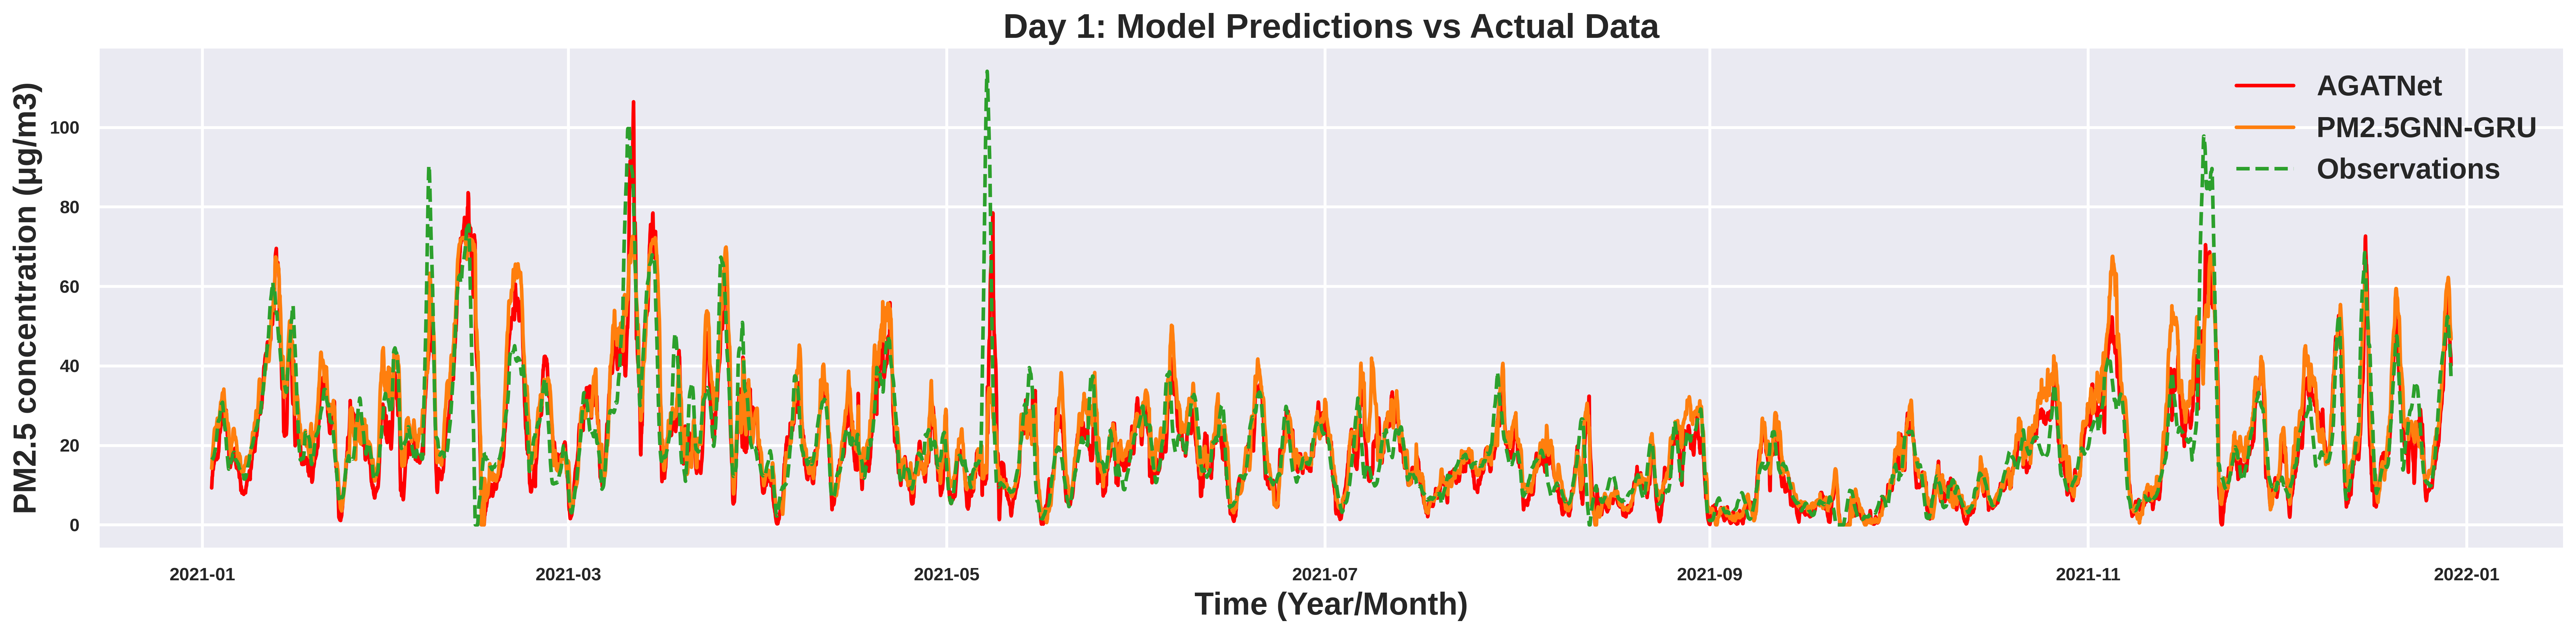

In [23]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib as mpl

plt.style.use('seaborn-poster') # This will make the figures larger and fonts more visible
date = np.array('2021-01-02 13', dtype=np.datetime64)
date = date + np.arange(8664)
# Create a figure with high DPI
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.figure(figsize=(20, 5), dpi=400)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.plot(date, np.mean(pred_agat[:, 20, :24], axis = 1), label='AGATNet', linewidth=2, color='r')
plt.plot(date, np.mean(pred_gnn[:, 20, :24], axis = 1), label='PM2.5GNN-GRU', linewidth=2, color=colors[1])
plt.plot(date, np.mean(labe_agat[:, 20, :24], axis = 1), label='Observations', linewidth=2, linestyle='--', color=colors[2])

# Add labels and title
plt.xlabel('Time (Year/Month)', fontweight='bold')
plt.ylabel('PM2.5 concentration (μg/m3)', fontweight='bold')
plt.title('Day 1: Model Predictions vs Actual Data', fontweight='bold')

# Add a legend
plt.legend()

# Customize the tick marks to be bold
plt.tick_params(axis='both', which='major', labelsize=10)

# Adjust the layout
plt.tight_layout()

# plt.savefig('/tng4/users/rdimri/time_series_day1.jpg', format='jpg', dpi=400, bbox_inches='tight')

# Show the plot
plt.show()

/tmp/ipykernel_4005119/636445461.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster') # This will make the figures larger and fonts more visible


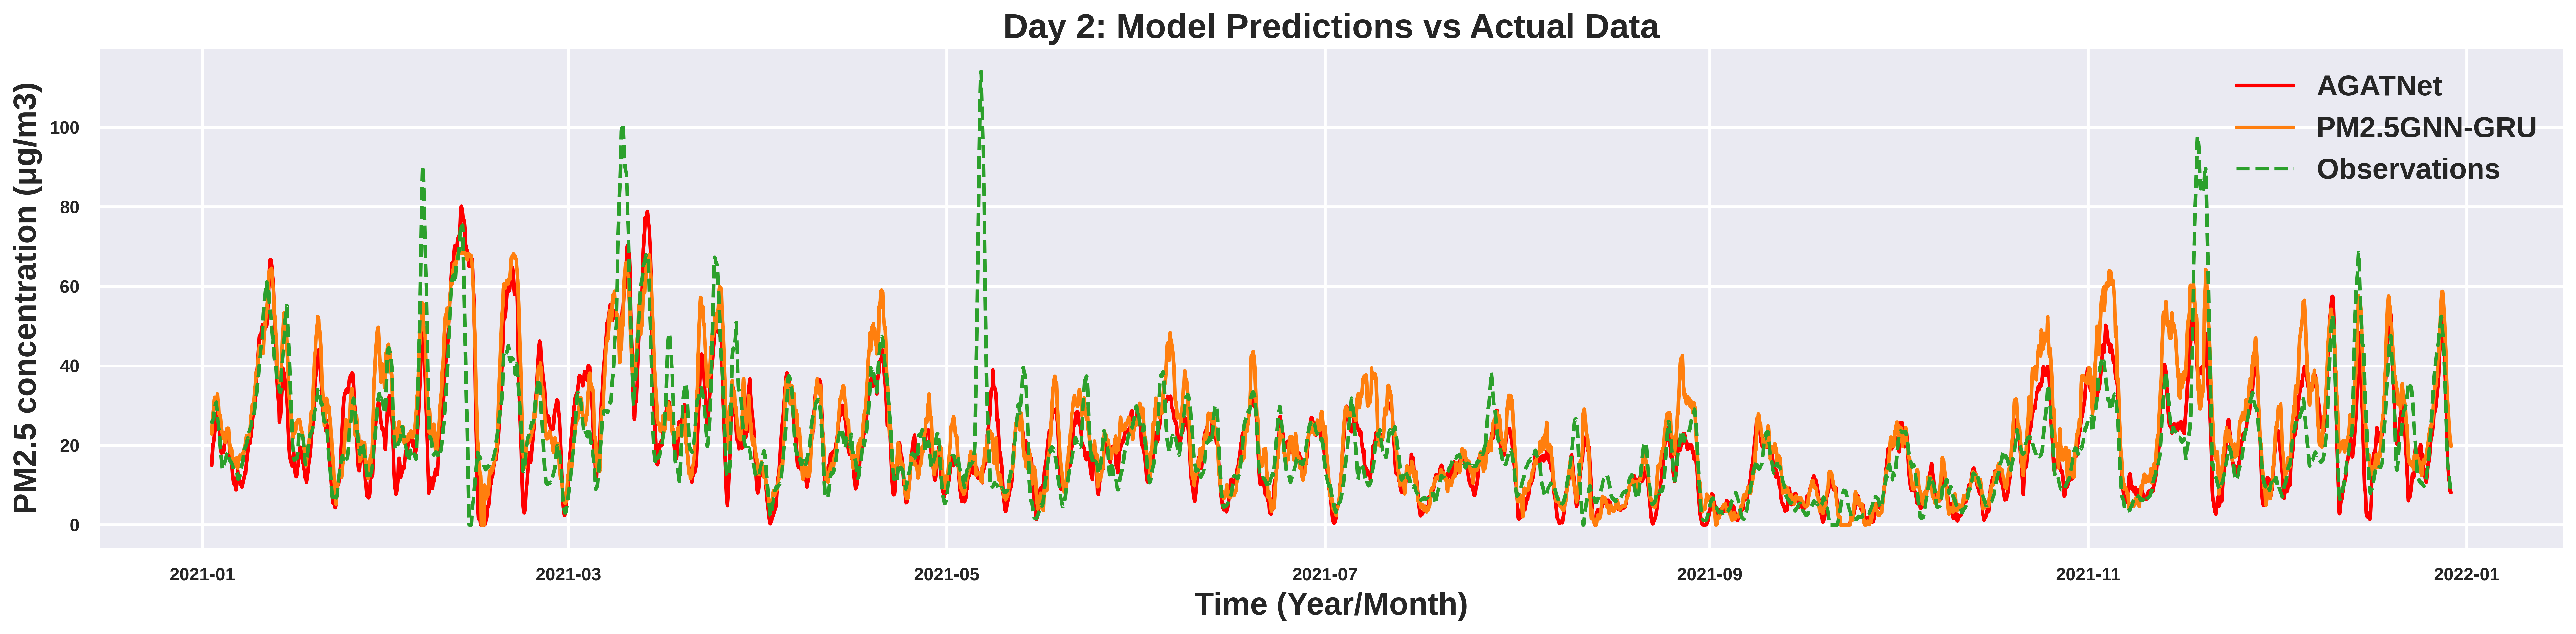

In [24]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib as mpl

plt.style.use('seaborn-poster') # This will make the figures larger and fonts more visible
date = np.array('2021-01-02 13', dtype=np.datetime64)
date = date + np.arange(8664)
# Create a figure with high DPI
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.figure(figsize=(20, 5), dpi=400)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.plot(date, np.mean(pred_agat[:, 20, 24:48], axis = 1), label='AGATNet', linewidth=2, color='r')
plt.plot(date, np.mean(pred_gnn[:, 20, 24:48], axis = 1), label='PM2.5GNN-GRU', linewidth=2, color=colors[1])
plt.plot(date, np.mean(labe_agat[:, 20, 24:48], axis = 1), label='Observations', linewidth=2, linestyle='--', color=colors[2])

# Add labels and title
plt.xlabel('Time (Year/Month)', fontweight='bold')
plt.ylabel('PM2.5 concentration (μg/m3)', fontweight='bold')
plt.title('Day 2: Model Predictions vs Actual Data', fontweight='bold')

# Add a legend
plt.legend()

# Customize the tick marks to be bold
plt.tick_params(axis='both', which='major', labelsize=10)

# Adjust the layout
plt.tight_layout()

# plt.savefig('/tng4/users/rdimri/time_series_day2.jpg', format='jpg', dpi=400, bbox_inches='tight')

# Show the plot
plt.show()

/tmp/ipykernel_4005119/292247222.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster') # This will make the figures larger and fonts more visible


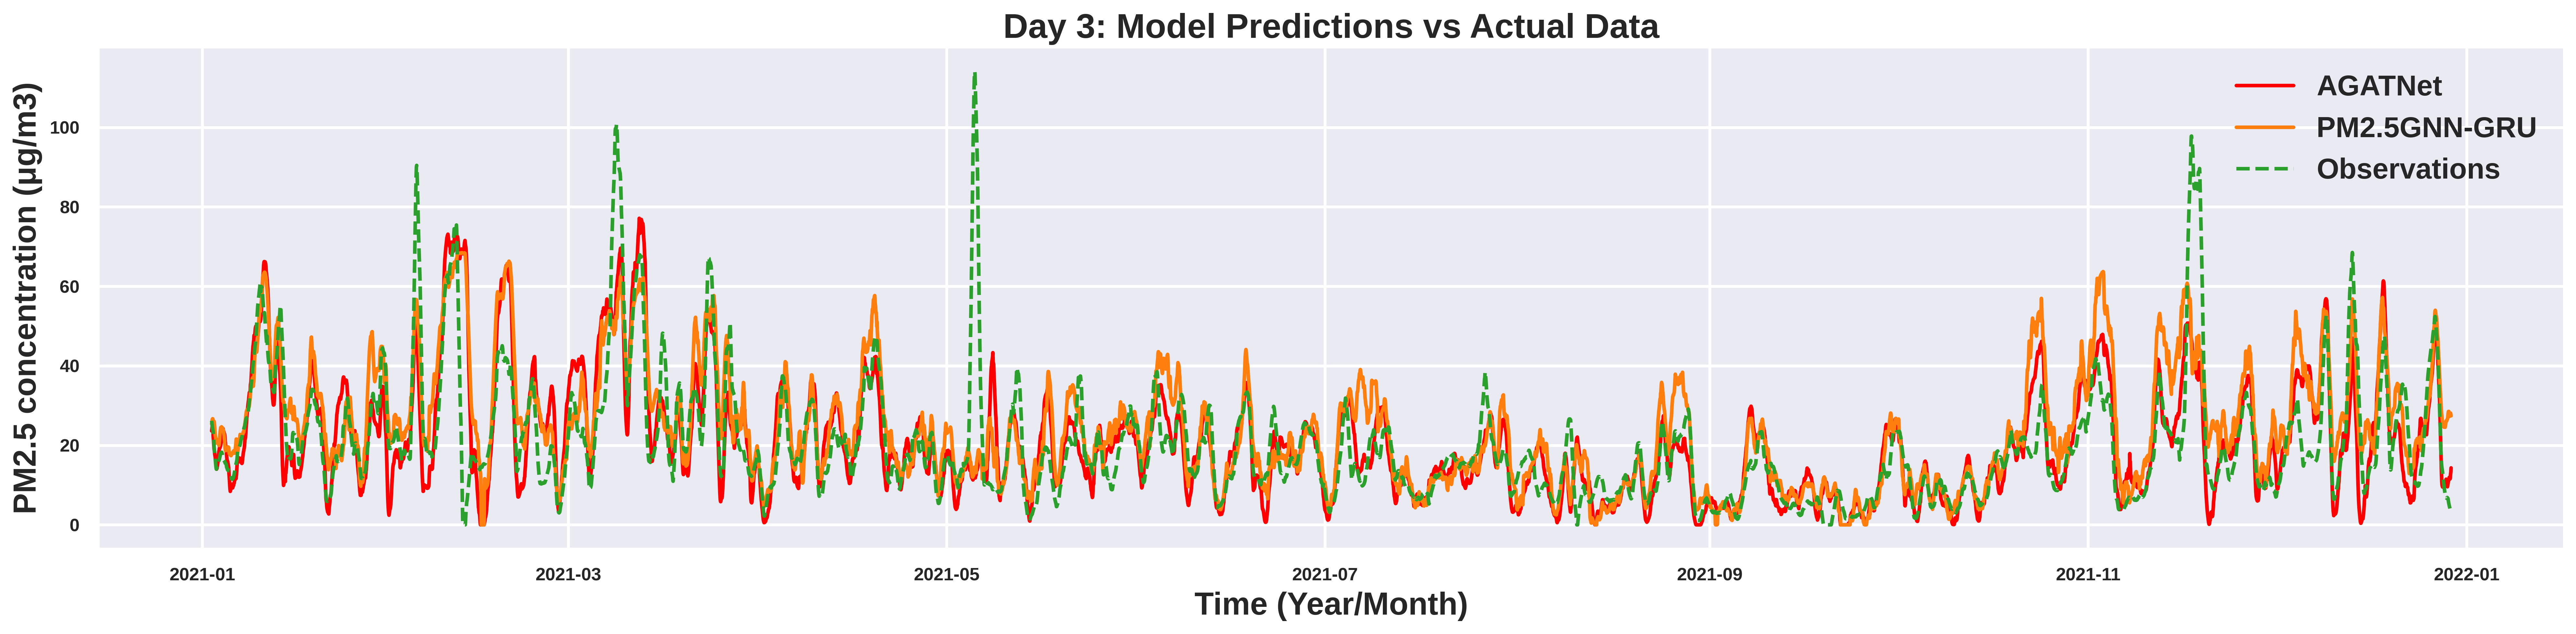

In [25]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib as mpl

plt.style.use('seaborn-poster') # This will make the figures larger and fonts more visible
date = np.array('2021-01-02 13', dtype=np.datetime64)
date = date + np.arange(8664)
# Create a figure with high DPI
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.figure(figsize=(20, 5), dpi=400)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.plot(date, np.mean(pred_agat[:, 20, 48:], axis = 1), label='AGATNet', linewidth=2, color='r')
plt.plot(date, np.mean(pred_gnn[:, 20, 48:], axis = 1), label='PM2.5GNN-GRU', linewidth=2, color=colors[1])
plt.plot(date, np.mean(labe_agat[:, 20, 48:], axis = 1), label='Observations', linewidth=2, linestyle='--', color=colors[2])

# Add labels and title
plt.xlabel('Time (Year/Month)', fontweight='bold')
plt.ylabel('PM2.5 concentration (μg/m3)', fontweight='bold')
plt.title('Day 3: Model Predictions vs Actual Data', fontweight='bold')

# Add a legend
plt.legend()

# Customize the tick marks to be bold
plt.tick_params(axis='both', which='major', labelsize=10)

# Adjust the layout
plt.tight_layout()

# plt.savefig('/tng4/users/rdimri/time_series_day3.jpg', format='jpg', dpi=400, bbox_inches='tight')

# Show the plot
plt.show()

In [47]:
province_names.shape

AttributeError: 'list' object has no attribute 'shape'

Province: Busan, Number of Stations: 19
Province: Chonbuk, Number of Stations: 1
Province: Chonnam, Number of Stations: 14
Province: Daegu, Number of Stations: 10
Province: Gangwon_West, Number of Stations: 2
Province: Gwangju, Number of Stations: 6
Province: Gyeongbuk, Number of Stations: 3
Province: Gyeonggi_North, Number of Stations: 17
Province: Gyeonggi_South, Number of Stations: 50
Province: Gyeongnam, Number of Stations: 19
Province: Jeju, Number of Stations: 3
Province: Seoul, Number of Stations: 25
Province: Ulsan, Number of Stations: 14


/tmp/ipykernel_4005119/2839381535.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(formatted_province_names, fontweight='bold')


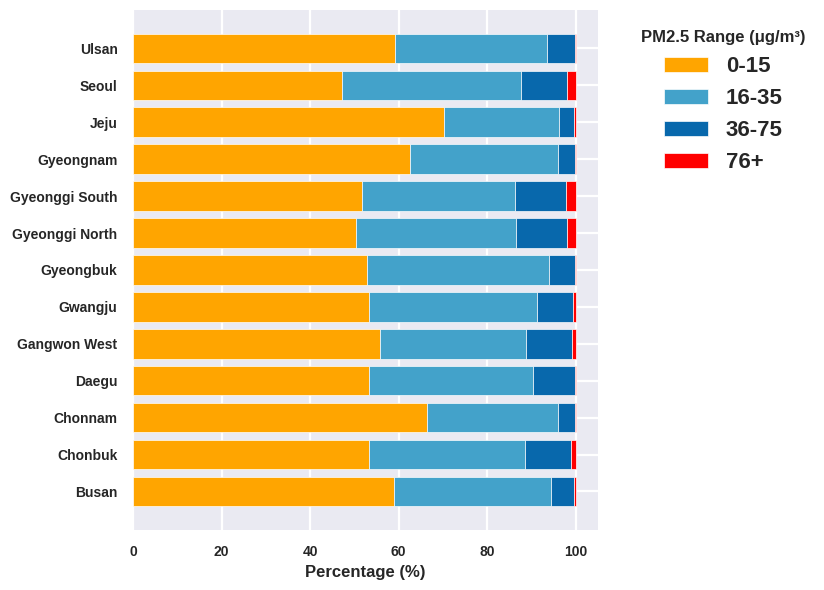

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

aqs_site_info_df = pd.read_csv('/tng4/users/rdimri/Korea_AQS_site_info_Oct_2021_updated.csv')
stations_info_df = pd.read_csv('/tng4/users/rdimri/stations_info_183_lat_lon.csv', header = None)
# province_names = list(province_indices.keys())
stations_info_df.columns = ['Lat', 'Lon', 'Station_ID']
merged_df = pd.merge(stations_info_df, aqs_site_info_df[['Station_ID', 'Province']], on='Station_ID', how='left')
merged_df.to_csv('/tng4/users/rdimri/merged_stations_info.csv')
province_indices = merged_df.groupby('Province').apply(lambda x: x.index.tolist()).to_dict()
province_names = list(province_indices.keys())
# province_names = [
#     "Busan", "Chonbuk", "Chonnam", "Daegu", "Gangwon_West", "Gwangju",
#     "Gyeongbuk", "Gyeonggi N", "Gyeonggi S", "Gyeongnam",
#     "Jeju", "Seoul", "Ulsan"
# ]
province_indices_length = {province: len(indices) for province, indices in province_indices.items()}


for province, length in province_indices_length.items():
    print(f"Province: {province}, Number of Stations: {length}")
    

province_flattened_data = {}
for province, indices in province_indices.items():
    province_data = labe_agat[:, indices, :].flatten()  # Flatten all samples and time steps for each station
    province_flattened_data[province] = province_data


pm25_bins = [0, 15, 35, 75, 500]
bin_labels = ['0-15', '16-35', '36-75', '76+']
# province_names = province_names[1:] 
province_distribution = pd.DataFrame(columns=bin_labels)

for i, province in enumerate(province_names):
    province_data = province_flattened_data[province]
    province_distribution.loc[province] = [
        (np.sum((province_data >= pm25_bins[j]) & (province_data < pm25_bins[j+1])) / len(province_data)) * 100
        for j in range(len(pm25_bins) - 1)
    ]
bin_colors = ['#FFA500', '#43a2ca', '#0868ac', '#FF0000', '#6E2C00']
cmap = mcolors.LinearSegmentedColormap.from_list('Custom cmap', bin_colors, len(bins) - 1)
# Create a colormap
# colors = ['#5e4fa2', '#3288bd', '#66c2a5', '#abdda4', '#e6f598', '#ffffbf',
#           '#fee08b', '#fdae61', '#f46d43', '#d53e4f', '#9e0142']
# cmap = mcolors.LinearSegmentedColormap.from_list('CustomMap', colors)
bounds = [0, 15, 35, 75, 500]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# We will plot each bin's percentage one by one to create the stacked effect
bottom = np.zeros(len(province_names))
# formatted_province_names = [name.replace('_', ' ') for name in province_names]

for i, bin_label in enumerate(bin_labels):
    ax.barh(province_names, province_distribution[bin_label], left=bottom, color=bin_colors[i], edgecolor='white', label=bin_label)
    bottom += province_distribution[bin_label].values

# Add a color bar at the bottom
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Necessary for the colorbar to work properly
ax.set_yticklabels(formatted_province_names, fontweight='bold')

# Formatting the plot
ax.set_xlabel('Percentage (%)', fontsize = 12, fontweight='bold')
for label in ax.get_xticklabels():
    label.set_weight('bold')

# ax.set_title('PM2.5 Distribution by Province', fontweight='bold')
# cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.2)
# cbar.set_label('PM2.5 Range (μg/m³)', fontsize=12, fontweight='bold')
# cbar.ax.xaxis.set_label_position('top')
# Move the legend out of the plot, on the right side
legend_title_font = FontProperties(weight='bold', size='large')
ax.legend(title='PM2.5 Range (μg/m³)', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'weight':'bold'}, title_fontproperties=legend_title_font)
# plt.setp(legend.get_title(), fontweight='bold')

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make space for the legend
# plt.savefig('/tng4/users/rdimri/distribution_PM25_korea.jpg', format = 'jpg', dpi = 400, bbox_inches = 'tight')
plt.show()


In [61]:
print(len(colors)) 
print(bin_labels)


3
['0-15', '16-35', '36-75', '76+']


In [57]:
province_names

['Busan',
 'Chonbuk',
 'Chonnam',
 'Daegu',
 'Gangwon_West',
 'Gwangju',
 'Gyeongbuk',
 'Gyeonggi_North',
 'Gyeonggi_South',
 'Gyeongnam',
 'Jeju',
 'Seoul',
 'Ulsan']

In [56]:
province_distribution

0-15      16-35      36-75       76+
Busan           59.013688  35.430343   5.269241  0.286728
Chonbuk         53.228397  35.323048  10.375147  1.073407
Chonnam         66.496651  29.587549   3.646566  0.269233
Daegu           53.310538  37.077562   9.356821  0.255078
Gangwon_West    55.841060  32.828611  10.458907  0.871422
Gwangju         53.271840  37.879417   8.235093  0.613650
Gyeongbuk       52.802465  41.206269   5.852762  0.138504
Gyeonggi_North  50.325128  36.115156  11.580015  1.979700
Gyeonggi_South  51.620592  34.683060  11.407824  2.288525
Gyeongnam       62.500869  33.528172   3.785072  0.185887
Jeju            70.249179  25.895628   3.355039  0.500154
Seoul           47.234303  40.417494  10.265601  2.082602
Ulsan           59.274946  34.250694   6.270725  0.203634